In [191]:
import matplotlib.pylab as plt
import numpy as np
import glob
from scipy.interpolate import UnivariateSpline
from shapely.geometry import LineString, Point
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import copy
import pandas as pd
import json 
%config InlineBackend.figure_format = 'retina'
!mkdir -p figures tables
atm_to_gpa=0.000101325
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
colors=['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999']*10


In [192]:
def intersection_point(gibbs_line1,gibbs_line2):
    line1 = LineString(gibbs_line1)
    line2 = LineString(gibbs_line2)
    int_pt = line2.intersection(line1)
    if int_pt.geom_type == 'Point':
        point_of_intersection = int_pt.x, int_pt.y
    else:
        int_pt=int_pt[0]
        point_of_intersection = int_pt.x, int_pt.y

    return point_of_intersection

In [193]:
def load_gibbs(fold,sort='P'):
    PT_IceIh_Liquid=glob.glob(fold+'/*_*_*')
    PT_IceIh_Liquid=[[int(a.split('/')[-1].split('_')[0]),float(a.split('/')[-1].split('_')[1]),float(a.split('/')[-1].split('_')[2])]  for a in PT_IceIh_Liquid]
    PT_IceIh_Liquid=np.array(PT_IceIh_Liquid)

    PT_IceIh_Liquid=PT_IceIh_Liquid[np.argsort(PT_IceIh_Liquid[:,0])]

    index_0=np.where(PT_IceIh_Liquid[:,0]==0)[0][0]
    
    PT_IceIh_Liquid=np.concatenate((PT_IceIh_Liquid[index_0::-4][::-1],PT_IceIh_Liquid[index_0::4][1:]),axis=0)

    PT_IceIh_Liquid=PT_IceIh_Liquid[:,1:]


    return PT_IceIh_Liquid

In [194]:
def load_multiple_gibbs(fold,sort='P'):
    ret=dict()
    for subfold in glob.glob(fold+'/*K/'):
        ret[subfold.split('/')[-2]]=load_gibbs(subfold,sort)
    return ret
                          

## Load simulation data

In [195]:

colors=['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999']*10

color_dict={'dnn': '#377eb8','classical':'#4daf4a','quantum':'#e41a1c','exp':'k','Ih':'#984ea3','II':'#ff7f00','III':'#999999','V':'#a65628','VI':'#f781bf','Liq':'#377eb8'}

color_dict_lines={'IceIh_Liquid':color_dict['Ih'],'IceII_Liquid':color_dict['II'],
                  'IceIII_Liquid':color_dict['III'],'IceV_Liquid':color_dict['V'],
                  'IceVI_Liquid':color_dict['VI'],'IceVI_IceV':color_dict['VI'],
                 'IceII_IceVI':color_dict['II'],'IceII_IceIh':color_dict['II'],
                'IceII_IceIII':color_dict['III'],'IceV_IceIII':color_dict['V'],
                  'IceIh_IceIII':color_dict['Ih'],'IceII_IceV':color_dict['Ih'],'IceII_IceVI_v2':color_dict['VI'],'IceII_IceV_v2':color_dict['V']}
ls_dict_lines={'IceIh_Liquid':'-','IceII_Liquid':'-',
                  'IceIII_Liquid':'-','IceV_Liquid':'-',
                  'IceVI_Liquid':'-','IceVI_IceV':'--',
                 'IceII_IceVI':'--','IceII_IceIh':'-.',
                'IceII_IceIII':'--','IceV_IceIII':'--',
                  'IceIh_IceIII':'--','IceII_IceV':'-.',
                  'IceII_IceVI_v2':'-.','IceII_IceV_v2':'-.'}




In [196]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline

def AvgLineP(lines):
    # Computes the average of Gibbs Duhem lines
    # using 1d cubic interpolation 


    pmax=max([lines[key][:,1].max() for key in lines.keys()])
    pmin=min([lines[key][:,1].min() for key in lines])
    P=np.linspace(pmin,pmax,10000)
    ret=P*0
    for key in lines.keys():
        ret+=interp1d(lines[key][:,1], lines[key][:,0],fill_value="extrapolate",kind='quadratic')(P)/len(lines.keys())
    
    return np.vstack((ret,P)).T
def Poly(meltingpoints,lines):
    pmax=max([lines[key][:,1].max() for key in lines.keys()])
    pmin=min([lines[key][:,1].min() for key in lines])
    P=np.linspace(0,pmax,10000)
    
    z = np.polyfit(meltingpoints[:,1], meltingpoints[:,0], 2)
    fn = np.poly1d(z)
    return np.vstack((fn(P),P)).T

## Read from pickle

In [200]:
with open('MeltingPointsDNN.pickle', 'rb') as f:
    MeltingPointsDNN = pickle.load(f)
with open('MeltingPointsClassical.pickle', 'rb') as f:
    MeltingPointsClassical = pickle.load(f)
with open('MeltingPointsQuantum.pickle', 'rb') as f:
    MeltingPointsQuantum = pickle.load(f)


with open('GibbsLinesDNN.pickle', 'rb') as f:
    GibbsLinesDNN = pickle.load(f)
with open('GibbsLinesClassical.pickle', 'rb') as f:
    GibbsLinesClassical = pickle.load(f)
with open('GibbsLinesQuantum.pickle', 'rb') as f:
    GibbsLinesQuantum = pickle.load(f)

## DNN@MB-pol

In [201]:
# MeltingPointsDNN=dict()
# MeltingPointsDNN['IceIh_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-Ih/3-BiasedCoexistence/DATA/melting-points-DNN.dat'))
# MeltingPointsDNN['IceII_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-II/1-BiasedCoexistence/DATA/melting-points-DNN.dat'))
# MeltingPointsDNN['IceIII_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-III/5-BiasedCoexistence/DATA/melting-points-DNN.dat'))
# MeltingPointsDNN['IceV_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-V/3-BiasedCoexistence/DATA/melting-points-DNN.dat'))
# MeltingPointsDNN['IceVI_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-VI/4-BiasedCoexistence/DATA/melting-points-DNN.dat'))

# GibbsLinesDNN=dict()
# GibbsLinesDNN['IceIh_Liquid']=load_multiple_gibbs('../Gibbs//Ih-Liq_NN/')
# GibbsLinesDNN['IceII_Liquid']=load_multiple_gibbs('../Gibbs//II-Liq_NN/')

# GibbsLinesDNN['IceIII_Liquid']=load_multiple_gibbs('../Gibbs//III-Liq_NN/')
# GibbsLinesDNN['IceVI_Liquid']=load_multiple_gibbs('../Gibbs//VI-Liq_NN/')
# GibbsLinesDNN['IceV_Liquid']=load_multiple_gibbs('../Gibbs//V-Liq_NN/')



#Add Neg Ih
# dat=load_multiple_gibbs('../Gibbs//Ih-Liq_NN_Neg/')
# for key in dat.keys():
#     GibbsLinesDNN['IceIh_Liquid'][key]=np.vstack((GibbsLinesDNN['IceIh_Liquid'][key],dat[key][:-1]))

In [202]:
GibbsLinesDNNAvg=dict()
for key in GibbsLinesDNN.keys():
    GibbsLinesDNNAvg[key]=AvgLineP(GibbsLinesDNN[key])
for key in ['IceIII_Liquid']:
    GibbsLinesDNNAvg[key]=Poly(MeltingPointsDNN[key][:,::-1],GibbsLinesDNN[key])
    

### Plot Gibbs lines

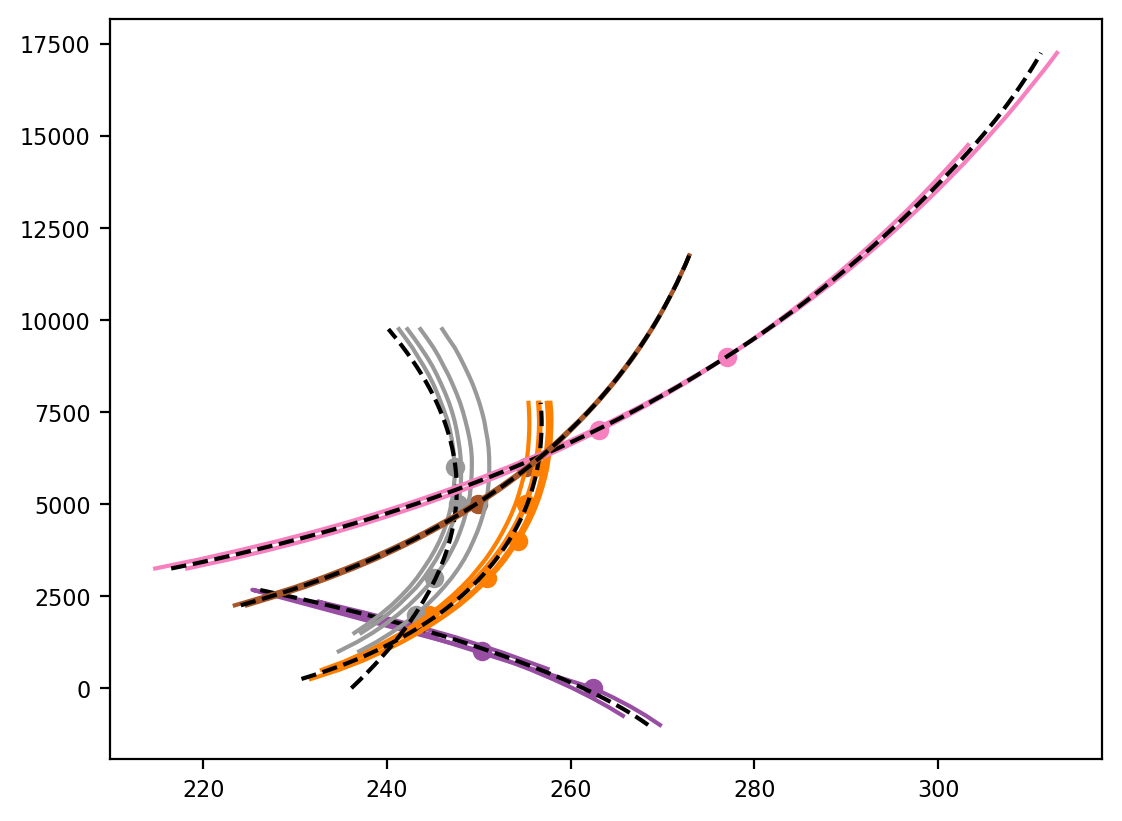

In [203]:
for gl in GibbsLinesDNN.keys():
    for line in GibbsLinesDNN[gl].keys():
        data=GibbsLinesDNN[gl][line]
        plt.plot(data[:,0],data[:,1],color=color_dict_lines[gl])
    data=GibbsLinesDNNAvg[gl]
    plt.plot(data[:,0],data[:,1],color='k',ls='--')
    data2=MeltingPointsDNN[gl]    
    plt.scatter(data2[:,1],data2[:,0],color=color_dict_lines[gl])


## Classical MB-pol

In [204]:
# MeltingPointsClassical=dict()
# MeltingPointsClassical['IceIh_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-Ih/3-BiasedCoexistence/DATA/melting-points-MB-pol-classical.dat'))
# MeltingPointsClassical['IceII_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-II/1-BiasedCoexistence/DATA/melting-points-MB-pol-classical.dat'))
# MeltingPointsClassical['IceIII_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-III/5-BiasedCoexistence/DATA/melting-points-MB-pol-classical.dat'))
# MeltingPointsClassical['IceV_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-V/3-BiasedCoexistence/DATA/melting-points-MB-pol-classical.dat'))
# MeltingPointsClassical['IceVI_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-VI/4-BiasedCoexistence/DATA/melting-points-MB-pol-classical.dat'))


# GibbsLinesClassical=dict()
# GibbsLinesClassical['IceIh_Liquid']=load_multiple_gibbs('../Gibbs//Ih-Liq_classical*/')
# GibbsLinesClassical['IceII_Liquid']=load_multiple_gibbs('../Gibbs//II-Liq_classical/')

# GibbsLinesClassical['IceIII_Liquid']=load_multiple_gibbs('../Gibbs//III-Liq_classical/')
# GibbsLinesClassical['IceVI_Liquid']=load_multiple_gibbs('../Gibbs//VI-Liq_classical/')
# GibbsLinesClassical['IceV_Liquid']=load_multiple_gibbs('../Gibbs//V-Liq_classical/')
# GibbsLinesClassicalAvg=dict()

# #Add Neg Ih
# dat=load_multiple_gibbs('../Gibbs//Ih-Liq_classical_Neg/')
# for key in dat.keys():
#     GibbsLinesClassical['IceIh_Liquid'][key]=np.vstack((GibbsLinesClassical['IceIh_Liquid'][key],dat[key][:-1]))

In [205]:
for key in GibbsLinesDNN.keys():
    GibbsLinesClassicalAvg[key]=AvgLineP(GibbsLinesClassical[key])
    
for key in ['IceIII_Liquid']:
    #print(MeltingPointsDNN[key])#[:,::-1])
    GibbsLinesClassicalAvg[key]=Poly(MeltingPointsClassical[key][:,::-1],GibbsLinesClassical[key])

### Plot Gibbs lines

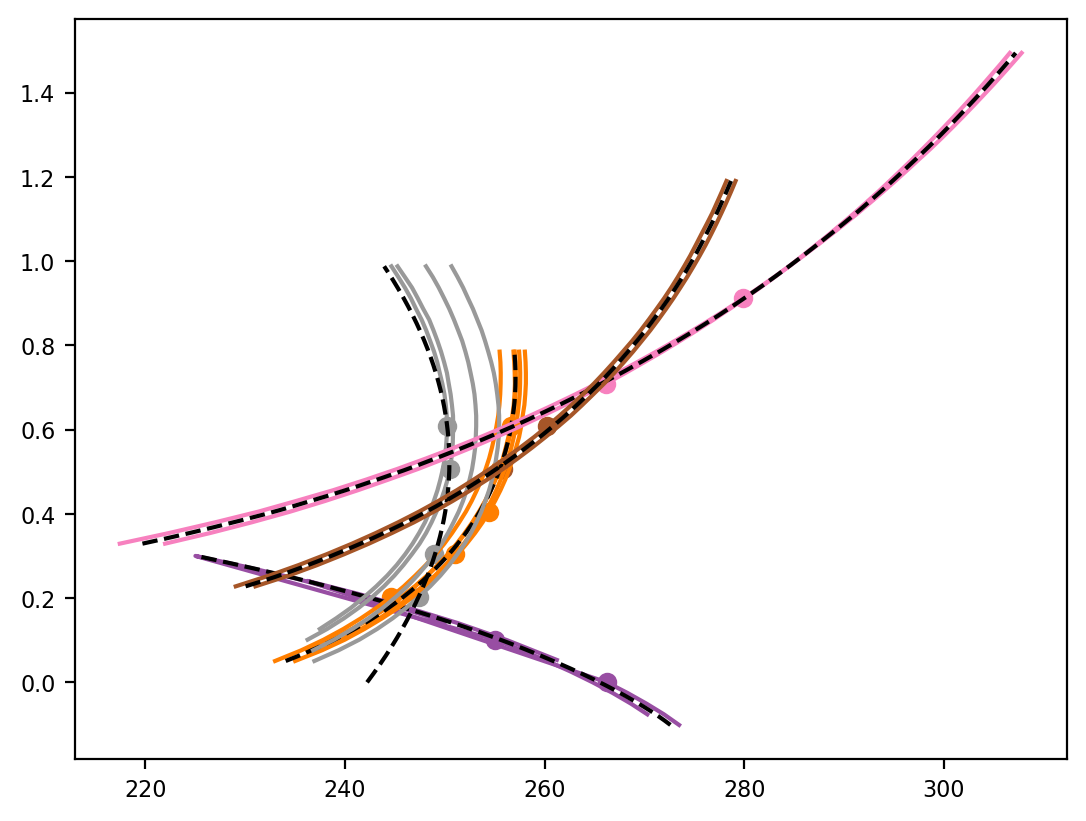

In [206]:
for gl in GibbsLinesClassical.keys():
    for line in GibbsLinesClassical[gl].keys():
        data=GibbsLinesClassical[gl][line]
        plt.plot(data[:,0],data[:,1]*atm_to_gpa,color=color_dict_lines[gl])
    data=GibbsLinesClassicalAvg[gl]
    plt.plot(data[:,0],data[:,1]*atm_to_gpa,color='k',ls='--')
    data2=MeltingPointsClassical[gl]
    plt.scatter(data2[:,1],data2[:,0]*atm_to_gpa,color=color_dict_lines[gl])


## Quantum MB-pol

In [207]:
# MeltingPointsQuantum=dict()
# MeltingPointsQuantum['IceIh_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-Ih/3-BiasedCoexistence/DATA/melting-points-MB-pol-quantum.dat'))
# MeltingPointsQuantum['IceII_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-II/1-BiasedCoexistence/DATA/melting-points-MB-pol-quantum.dat'))
# MeltingPointsQuantum['IceIII_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-III/5-BiasedCoexistence/DATA/melting-points-MB-pol-quantum.dat'))
# MeltingPointsQuantum['IceV_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-V/3-BiasedCoexistence/DATA/melting-points-MB-pol-quantum.dat'))
# MeltingPointsQuantum['IceVI_Liquid']=np.atleast_2d(np.loadtxt('../EnhancedCoexistence/Liq-VI/4-BiasedCoexistence/DATA/melting-points-MB-pol-quantum.dat'))

# GibbsLinesQuantum=dict()
# GibbsLinesQuantum['IceIh_Liquid']=load_multiple_gibbs('../Gibbs//Ih-Liq_quantum/')
# GibbsLinesQuantum['IceII_Liquid']=load_multiple_gibbs('../Gibbs//II-Liq_quantum/')

# GibbsLinesQuantum['IceIII_Liquid']=load_multiple_gibbs('../Gibbs//III-Liq_quantum/')
# #GibbsLinesNN['IceIII_Liquid']=GibbsLines['IceIII_Liquid'][GibbsLines['IceIII_Liquid_NN'][:,1]<10000]
# GibbsLinesQuantum['IceVI_Liquid']=load_multiple_gibbs('../Gibbs//VI-Liq_quantum/')
# GibbsLinesQuantum['IceV_Liquid']=load_multiple_gibbs('../Gibbs//V-Liq_quantum/')

# #Add Neg Ih
# dat=load_multiple_gibbs('../Gibbs//Ih-Liq_quantum_Neg/')
# for key in dat.keys():
#     GibbsLinesQuantum['IceIh_Liquid'][key]=np.vstack((GibbsLinesQuantum['IceIh_Liquid'][key],dat[key][:-1]))



In [208]:
GibbsLinesQuantumAvg=dict()
for key in GibbsLinesQuantum.keys():
    GibbsLinesQuantumAvg[key]=AvgLineP(GibbsLinesQuantum[key])
for key in ['IceIII_Liquid']:
    GibbsLinesQuantumAvg[key]=Poly(MeltingPointsQuantum[key][:,::-1],GibbsLinesQuantum[key])

### Plot Gibbs lines

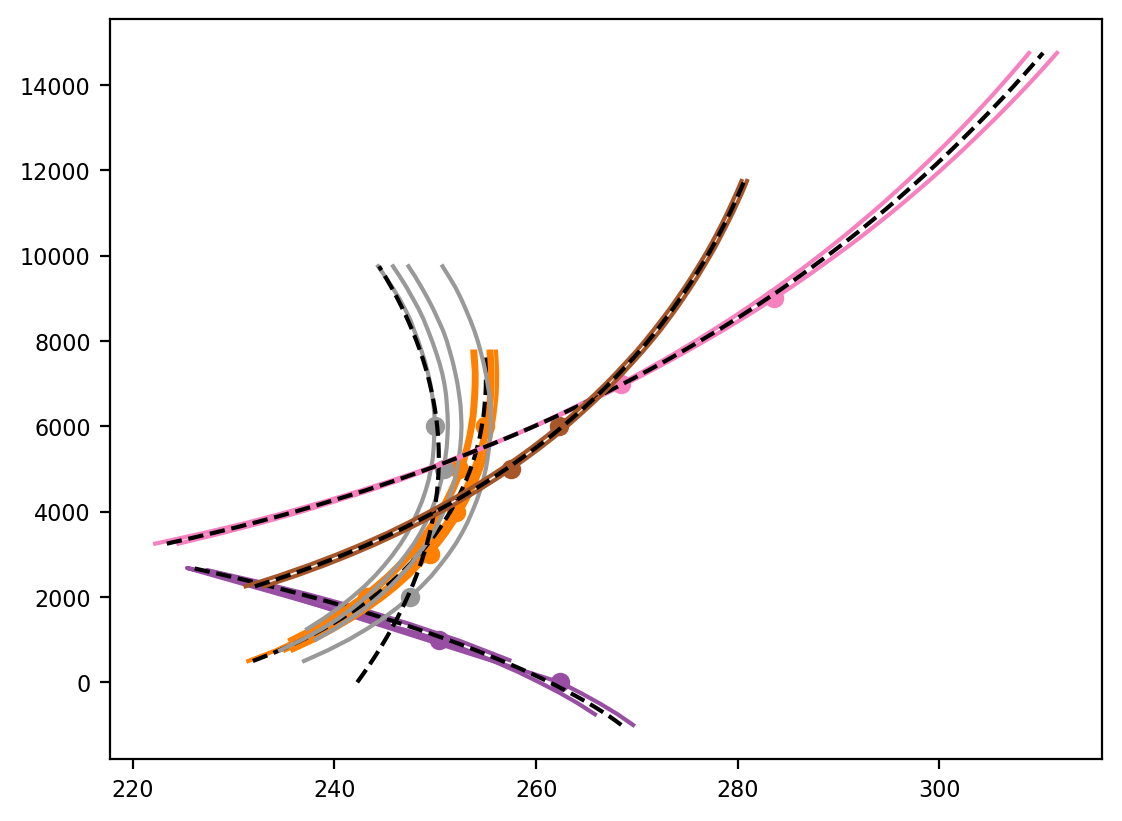

In [209]:
for gl in GibbsLinesQuantum.keys():
    for line in GibbsLinesQuantum[gl].keys():
        data=GibbsLinesQuantum[gl][line]
        plt.plot(data[:,0],data[:,1],color=color_dict_lines[gl])
    data2=MeltingPointsQuantum[gl]
    data=GibbsLinesQuantumAvg[gl]
    plt.plot(data[:,0],data[:,1],color='k',ls='--')
    plt.scatter(data2[:,1],data2[:,0],color=color_dict_lines[gl])


## Add ice-ice

In [210]:
GibbsLinesDNNAvg['IceII_IceIh']=load_gibbs('../Gibbs//II-Ih_NN/*K/')
GibbsLinesDNNAvg['IceV_IceVI']=load_gibbs('../Gibbs//VI-V_NN/*K/')
GibbsLinesDNNAvg['IceII_IceVI']=load_gibbs('../Gibbs//II-VI_NN/*K/')


GibbsLinesClassicalAvg['IceV_IceVI']=load_gibbs('../Gibbs//VI-V_classical/*K/')
GibbsLinesClassicalAvg['IceII_IceV']=load_gibbs('../Gibbs//II-V_classical/*K/')
GibbsLinesClassicalAvg['IceII_IceIII']=load_gibbs('../Gibbs//II-III_classical/*K/')
GibbsLinesClassicalAvg['IceIh_IceIII']=load_gibbs('../Gibbs//Ih-III_classical/*K/')
GibbsLinesClassicalAvg['IceII_IceIh']=load_gibbs('../Gibbs//Ih-II_classical/*K/')
GibbsLinesClassicalAvg['IceII_IceVI']=load_gibbs('../Gibbs//II-VI_classical/*K/')

GibbsLinesQuantumAvg['IceV_IceVI']=load_gibbs('../Gibbs//VI-V_quantum/*K/')
GibbsLinesQuantumAvg['IceII_IceV']=load_gibbs('../Gibbs//II-V_quantum/*K/')
GibbsLinesQuantumAvg['IceII_IceIII']=load_gibbs('../Gibbs//II-III_quantum/*K/')
GibbsLinesQuantumAvg['IceIh_IceIII']=load_gibbs('../Gibbs//Ih-III_quantum/*K/')
GibbsLinesQuantumAvg['IceII_IceIh']=load_gibbs('../Gibbs//Ih-II_quantum/*K/')
GibbsLinesQuantumAvg['IceII_IceVI']=load_gibbs('../Gibbs//II-VI_quantum/*K/')



## Read dictionaries containing the Gibbs lines 


In [211]:
# with open('GibbsLinesDNNAvg.pickle', 'wb') as f:
#     pickle.dump(GibbsLinesDNNAvg, f) 
# with open('GibbsLinesQuantumAvg.pickle', 'wb') as f:
#     pickle.dump(GibbsLinesClassicalAvg, f) 
# with open('GibbsLinesQuantumAvg.pickle', 'wb') as f:
#     pickle.dump(GibbsLinesQuantumAvg, f) 

# with open('MeltingPointsQuantum.pickle', 'wb') as f:
#     pickle.dump(MeltingPointsQuantum, f)
# with open('MeltingPointsClassical.pickle', 'wb') as f:
#     pickle.dump(MeltingPointsClassical, f)
# with open('MeltingPointsDNN.pickle', 'wb') as f:
#     pickle.dump(MeltingPointsDNN, f)


# with open('GibbsLinesDNN.pickle', 'wb') as f:
#     pickle.dump(GibbsLinesDNN, f)
# with open('GibbsLinesClassical.pickle', 'wb') as f:
#     pickle.dump(GibbsLinesClassical, f)
# with open('GibbsLinesQuantum.pickle', 'wb') as f:
#     pickle.dump(GibbsLinesQuantum, f)


# with open('GibbsLinesDNNAvg.pickle', 'rb') as f:
#     GibbsLinesDNNAvg = pickle.load(f)
# with open('GibbsLinesQuantumAvg.pickle', 'rb') as f:
#     GibbsLinesClassicalAvg = pickle.load(f)
# with open('GibbsLinesQuantumAvg.pickle', 'rb') as f:
#     GibbsLinesQuantumAvg = pickle.load(f)    


# with open('MeltingPointsDNN.pickle', 'rb') as f:
#     MeltingPointsDNN = pickle.load(f)
# with open('MeltingPointsClassical.pickle', 'rb') as f:
#     MeltingPointsClassical = pickle.load(f)
# with open('MeltingPointsQuantum.pickle', 'rb') as f:
#     MeltingPointsQuantum = pickle.load(f)


# with open('GibbsLinesDNN.pickle', 'rb') as f:
#     GibbsLinesDNN = pickle.load(f)
# with open('GibbsLinesClassical.pickle', 'rb') as f:
#     GibbsLinesClassical = pickle.load(f)
# with open('GibbsLinesQuantum.pickle', 'rb') as f:
#     GibbsLinesQuantum = pickle.load(f)

## Determine Triple points

In [212]:
trip_pts_NN={}
trip_pts_NN['Liquid IceIII IceV']= intersection_point(GibbsLinesDNNAvg['IceIII_Liquid'],GibbsLinesDNNAvg['IceV_Liquid'])
trip_pts_NN['Liquid IceIh IceII']= intersection_point(GibbsLinesDNNAvg['IceIh_Liquid'],GibbsLinesDNNAvg['IceII_Liquid'])
trip_pts_NN['Liquid IceV IceVI']= intersection_point(GibbsLinesDNNAvg['IceV_Liquid'],GibbsLinesDNNAvg['IceVI_Liquid'])
trip_pts_NN['Liquid IceII IceV']= intersection_point(GibbsLinesDNNAvg['IceII_Liquid'],GibbsLinesDNNAvg['IceV_Liquid'])
trip_pts_NN['Liquid IceII IceVI']= intersection_point(GibbsLinesDNNAvg['IceII_Liquid'],GibbsLinesDNNAvg['IceVI_Liquid'])


with open('triple_points_NN.dat','w') as fp:
    for key in trip_pts_NN:
        line='{}\t{:.2f}\t{:.2f}\n'.format(key,trip_pts_NN[key][0],trip_pts_NN[key][1])
        fp.write(line)
!cat triple_points_NN.dat        


Liquid IceIII IceV	247.38	4644.90
Liquid IceIh IceII	243.32	1624.37
Liquid IceV IceVI	257.02	6337.61
Liquid IceII IceV	256.57	6242.14
Liquid IceII IceVI	256.60	6291.33


In [213]:
trip_pts_classical={}
trip_pts_classical['Liquid IceIII IceV']= intersection_point(GibbsLinesClassicalAvg['IceIII_Liquid'],GibbsLinesClassicalAvg['IceV_Liquid'])
trip_pts_classical['Liquid IceIh IceII']= intersection_point(GibbsLinesClassicalAvg['IceIh_Liquid'],GibbsLinesClassicalAvg['IceII_Liquid'])
trip_pts_classical['Liquid IceIh IceIII']= intersection_point(GibbsLinesClassicalAvg['IceIh_Liquid'],GibbsLinesClassicalAvg['IceIII_Liquid'])

trip_pts_classical['Liquid IceV IceVI']= intersection_point(GibbsLinesClassicalAvg['IceV_Liquid'],GibbsLinesClassicalAvg['IceVI_Liquid'])
trip_pts_classical['Liquid IceII IceV']= intersection_point(GibbsLinesClassicalAvg['IceII_Liquid'],GibbsLinesClassicalAvg['IceV_Liquid'])
trip_pts_classical['Liquid IceII IceVI']= intersection_point(GibbsLinesClassicalAvg['IceII_Liquid'],GibbsLinesClassicalAvg['IceVI_Liquid'])
trip_pts_classical['Liquid IceII IceIII']= intersection_point(GibbsLinesClassicalAvg['IceII_Liquid'],GibbsLinesClassicalAvg['IceIII_Liquid'])


trip_pts_classical['IceIh IceII IceIII']= intersection_point(GibbsLinesClassicalAvg['IceIh_IceIII'],GibbsLinesClassicalAvg['IceII_IceIII'])
trip_pts_classical['IceII IceV IceVI']= intersection_point(GibbsLinesClassicalAvg['IceII_IceV'],GibbsLinesClassicalAvg['IceV_IceVI'])


with open('triple_points_classical.dat','w') as fp:
    for key in trip_pts_classical:
        line='{}\t{:.2f}\t{:.2f}\n'.format(key,trip_pts_classical[key][0],trip_pts_classical[key][1])
        fp.write(line)
!cat triple_points_classical.dat  

Liquid IceIII IceV	250.21	4269.72
Liquid IceIh IceII	244.83	1823.94
Liquid IceIh IceIII	246.73	1692.01
Liquid IceV IceVI	265.18	6937.93
Liquid IceII IceV	255.62	5072.82
Liquid IceII IceVI	256.63	5978.06
Liquid IceII IceIII	248.22	2473.41
IceIh IceII IceIII	242.69	1724.55
IceII IceV IceVI	227.08	6576.93


In [214]:
trip_pts_quantum={}
trip_pts_quantum['Liquid IceIII IceV']= intersection_point(GibbsLinesQuantumAvg['IceIII_Liquid'],GibbsLinesQuantumAvg['IceV_Liquid'])
trip_pts_quantum['Liquid IceIh IceII']= intersection_point(GibbsLinesQuantumAvg['IceIh_Liquid'],GibbsLinesQuantumAvg['IceII_Liquid'])
trip_pts_quantum['Liquid IceIh IceIII']= intersection_point(GibbsLinesQuantumAvg['IceIh_Liquid'],GibbsLinesQuantumAvg['IceIII_Liquid'])

trip_pts_quantum['Liquid IceV IceVI']= intersection_point(GibbsLinesQuantumAvg['IceV_Liquid'],GibbsLinesQuantumAvg['IceVI_Liquid'])
trip_pts_quantum['Liquid IceII IceV']= intersection_point(GibbsLinesQuantumAvg['IceII_Liquid'],GibbsLinesQuantumAvg['IceV_Liquid'])
trip_pts_quantum['Liquid IceII IceVI']= intersection_point(GibbsLinesQuantumAvg['IceII_Liquid'],GibbsLinesQuantumAvg['IceVI_Liquid'])
trip_pts_quantum['Liquid IceII IceIII']= intersection_point(GibbsLinesQuantumAvg['IceII_Liquid'],GibbsLinesQuantumAvg['IceIII_Liquid'])


trip_pts_quantum['IceIh IceII IceIII']= intersection_point(GibbsLinesQuantumAvg['IceIh_IceIII'],GibbsLinesQuantumAvg['IceII_IceIII'])
trip_pts_quantum['IceII IceV IceVI']= intersection_point(GibbsLinesQuantumAvg['IceII_IceV'],GibbsLinesQuantumAvg['IceV_IceVI'])

with open('triple_points_quantum.dat','w') as fp:
    for key in trip_pts_quantum:
        line='{}\t{:.2f}\t{:.2f}\n'.format(key,trip_pts_quantum[key][0],trip_pts_quantum[key][1])
        fp.write(line)
!cat triple_points_quantum.dat  

Liquid IceIII IceV	249.88	3982.26
Liquid IceIh IceII	242.10	1707.97
Liquid IceIh IceIII	246.04	1418.67
Liquid IceV IceVI	265.79	6659.41
Liquid IceII IceV	252.15	4281.79
Liquid IceII IceVI	254.08	5436.49
Liquid IceII IceIII	249.11	3196.69
IceIh IceII IceIII	237.15	1499.13
IceII IceV IceVI	216.48	6240.45


### Determine stable and metstable lines

In [215]:
#DNN@MB-pol
St_lines_NN=dict() #Stable part of coexistence lines
Mst_lines_NN=dict()#Metastable part of coexistence lines

#Ih
St_lines_NN['IceIh_Liquid']=GibbsLinesDNNAvg['IceIh_Liquid']
St_lines_NN['IceIh_Liquid']=St_lines_NN['IceIh_Liquid'][St_lines_NN['IceIh_Liquid'][:,1]<=trip_pts_NN['Liquid IceIh IceII'][1]]
St_lines_NN['IceIh_Liquid']=np.vstack((St_lines_NN['IceIh_Liquid'],trip_pts_NN['Liquid IceIh IceII']))
Mst_lines_NN['IceIh_Liquid']=[np.array([trip_pts_NN['Liquid IceIh IceII']]+[val for val in GibbsLinesDNNAvg['IceIh_Liquid'] if val not in St_lines_NN['IceIh_Liquid']])]


#II
St_lines_NN['IceII_Liquid']=GibbsLinesDNNAvg['IceII_Liquid']
St_lines_NN['IceII_Liquid']=St_lines_NN['IceII_Liquid'][St_lines_NN['IceII_Liquid'][:,1]<=trip_pts_NN['Liquid IceII IceVI'][1]]
St_lines_NN['IceII_Liquid']=np.vstack((St_lines_NN['IceII_Liquid'],trip_pts_NN['Liquid IceII IceVI']))
St_lines_NN['IceII_Liquid']=St_lines_NN['IceII_Liquid'][St_lines_NN['IceII_Liquid'][:,1]>=trip_pts_NN['Liquid IceIh IceII'][1]]
St_lines_NN['IceII_Liquid']=np.vstack((trip_pts_NN['Liquid IceIh IceII'],St_lines_NN['IceII_Liquid'],))

line1=GibbsLinesDNNAvg['IceII_Liquid']
line1=line1[line1[:,1]>=trip_pts_NN['Liquid IceII IceVI'][1]]
line1=np.vstack((line1,))
line2=GibbsLinesDNNAvg['IceII_Liquid']
line2=line2[line2[:,1]<=trip_pts_NN['Liquid IceIh IceII'][1]]
line2=np.vstack((line2))
Mst_lines_NN['IceII_Liquid']=[line1,line2]


#VI
St_lines_NN['IceVI_Liquid']=GibbsLinesDNNAvg['IceVI_Liquid']
St_lines_NN['IceVI_Liquid']=St_lines_NN['IceVI_Liquid'][St_lines_NN['IceVI_Liquid'][:,1]>=trip_pts_NN['Liquid IceII IceVI'][1]]
St_lines_NN['IceVI_Liquid']=np.vstack((trip_pts_NN['Liquid IceII IceVI'],St_lines_NN['IceVI_Liquid']))
Mst_lines_NN['IceVI_Liquid']=GibbsLinesDNNAvg['IceVI_Liquid']
Mst_lines_NN['IceVI_Liquid']=Mst_lines_NN['IceVI_Liquid'][Mst_lines_NN['IceVI_Liquid'][:,1]<=trip_pts_NN['Liquid IceII IceVI'][1]]
Mst_lines_NN['IceVI_Liquid']=[np.vstack((Mst_lines_NN['IceVI_Liquid'],trip_pts_NN['Liquid IceII IceVI']))]

#V and III
Mst_lines_NN['IceIII_Liquid']=[GibbsLinesDNNAvg['IceIII_Liquid']]
Mst_lines_NN['IceV_Liquid']=[GibbsLinesDNNAvg['IceV_Liquid']]



#II and VI
St_lines_NN['IceII_IceVI']=GibbsLinesDNNAvg['IceII_IceVI']

#II and Ih
St_lines_NN['IceII_IceIh']=GibbsLinesDNNAvg['IceII_IceIh']




In [216]:
#Classical MB-pol
St_lines_Classical=dict() #Stable part of coexistence lines
Mst_lines_Classical=dict()#Metastable part of coexistence lines
#Ih
St_lines_Classical['IceIh_Liquid']=GibbsLinesClassicalAvg['IceIh_Liquid']
St_lines_Classical['IceIh_Liquid']=St_lines_Classical['IceIh_Liquid'][St_lines_Classical['IceIh_Liquid'][:,1]<=trip_pts_classical['Liquid IceIh IceIII'][1]]
St_lines_Classical['IceIh_Liquid']=np.vstack((St_lines_Classical['IceIh_Liquid'],trip_pts_classical['Liquid IceIh IceIII']))
line1=GibbsLinesClassicalAvg['IceIh_Liquid']
line1=line1[line1[:,1]>=trip_pts_classical['Liquid IceIh IceIII'][1]]
line1=np.vstack((trip_pts_classical['Liquid IceIh IceIII'],line1))
Mst_lines_Classical['IceIh_Liquid']=[line1]



#II
St_lines_Classical['IceII_Liquid']=GibbsLinesClassicalAvg['IceII_Liquid']
St_lines_Classical['IceII_Liquid']=St_lines_Classical['IceII_Liquid'][St_lines_Classical['IceII_Liquid'][:,1]<=trip_pts_classical['Liquid IceII IceV'][1]]
St_lines_Classical['IceII_Liquid']=np.vstack((St_lines_Classical['IceII_Liquid'],trip_pts_classical['Liquid IceII IceV']))
St_lines_Classical['IceII_Liquid']=St_lines_Classical['IceII_Liquid'][St_lines_Classical['IceII_Liquid'][:,1]>=trip_pts_classical['Liquid IceII IceIII'][1]]
St_lines_Classical['IceII_Liquid']=np.vstack((trip_pts_classical['Liquid IceII IceIII'],St_lines_Classical['IceII_Liquid']))
line1=GibbsLinesClassicalAvg['IceII_Liquid']
line1=line1[line1[:,1]>=trip_pts_classical['Liquid IceII IceV'][1]]
line1=np.vstack((line1,))
line2=GibbsLinesClassicalAvg['IceII_Liquid']
line2=line2[line2[:,1]<=trip_pts_classical['Liquid IceII IceV'][1]]
line2=np.vstack((line2,))
Mst_lines_Classical['IceII_Liquid']=[line1,line2]


#III
St_lines_Classical['IceIII_Liquid']=GibbsLinesClassicalAvg['IceIII_Liquid'][GibbsLinesClassicalAvg['IceIII_Liquid'][:,1]<=trip_pts_classical['Liquid IceII IceIII'][1]]
St_lines_Classical['IceIII_Liquid']=np.vstack((St_lines_Classical['IceIII_Liquid'],trip_pts_classical['Liquid IceII IceIII']))
St_lines_Classical['IceIII_Liquid']=St_lines_Classical['IceIII_Liquid'][St_lines_Classical['IceIII_Liquid'][:,1]>=trip_pts_classical['Liquid IceIh IceIII'][1]]
St_lines_Classical['IceIII_Liquid']=np.vstack((trip_pts_classical['Liquid IceIh IceIII'],St_lines_Classical['IceIII_Liquid'],))
line1=GibbsLinesClassicalAvg['IceIII_Liquid'][GibbsLinesClassicalAvg['IceIII_Liquid'][:,1]>=trip_pts_classical['Liquid IceII IceIII'][1]]
line1=np.vstack((trip_pts_classical['Liquid IceII IceIII'],line1,))
line2=GibbsLinesClassicalAvg['IceIII_Liquid'][GibbsLinesClassicalAvg['IceIII_Liquid'][:,1]<=trip_pts_classical['Liquid IceIh IceIII'][1]]
Mst_lines_Classical['IceIII_Liquid']=[line1,line2]

#V
St_lines_Classical['IceV_Liquid']=GibbsLinesClassicalAvg['IceV_Liquid']
St_lines_Classical['IceV_Liquid']=St_lines_Classical['IceV_Liquid'][St_lines_Classical['IceV_Liquid'][:,1]>=trip_pts_classical['Liquid IceII IceV'][1]]
St_lines_Classical['IceV_Liquid']=np.vstack((trip_pts_classical['Liquid IceII IceV'],St_lines_Classical['IceV_Liquid']))
St_lines_Classical['IceV_Liquid']=St_lines_Classical['IceV_Liquid'][St_lines_Classical['IceV_Liquid'][:,1]<=trip_pts_classical['Liquid IceV IceVI'][1]]
St_lines_Classical['IceV_Liquid']=np.vstack((St_lines_Classical['IceV_Liquid'],trip_pts_classical['Liquid IceV IceVI']))
line1=GibbsLinesClassicalAvg['IceV_Liquid']
line1=line1[line1[:,1]>=trip_pts_classical['Liquid IceV IceVI'][1]]
line2=GibbsLinesClassicalAvg['IceV_Liquid']
line2=line2[line2[:,1]<=trip_pts_classical['Liquid IceII IceV'][1]]
Mst_lines_Classical['IceV_Liquid']=[line1,line2]

#VI
St_lines_Classical['IceVI_Liquid']=GibbsLinesClassicalAvg['IceVI_Liquid']
St_lines_Classical['IceVI_Liquid']=St_lines_Classical['IceVI_Liquid'][St_lines_Classical['IceVI_Liquid'][:,1]>=trip_pts_classical['Liquid IceV IceVI'][1]]
St_lines_Classical['IceVI_Liquid']=np.vstack((trip_pts_classical['Liquid IceV IceVI'],St_lines_Classical['IceVI_Liquid']))
line1=GibbsLinesClassicalAvg['IceVI_Liquid']
line1=line1[line1[:,1]<=trip_pts_classical['Liquid IceV IceVI'][1]]
line1=np.vstack((line1,trip_pts_classical['Liquid IceV IceVI']))
Mst_lines_Classical['IceVI_Liquid']=[line1]

#Ih and III
St_lines_Classical['IceIh_IceIII']=GibbsLinesClassicalAvg['IceIh_IceIII']
St_lines_Classical['IceIh_IceIII']=St_lines_Classical['IceIh_IceIII'][St_lines_Classical['IceIh_IceIII'][:,0]>=trip_pts_classical['IceIh IceII IceIII'][0]]
St_lines_Classical['IceIh_IceIII']=np.vstack((St_lines_Classical['IceIh_IceIII'],trip_pts_classical['IceIh IceII IceIII']))
Mst_lines_Classical['IceIh_IceIII']=[np.array([[val for val in GibbsLinesClassicalAvg['IceIh_IceIII'] if val not in St_lines_Classical['IceIh_IceIII']]+[trip_pts_classical['IceIh IceII IceIII']]])]



#II and III
St_lines_Classical['IceII_IceIII']=GibbsLinesClassicalAvg['IceII_IceIII']
St_lines_Classical['IceII_IceIII']=St_lines_Classical['IceII_IceIII'][St_lines_Classical['IceII_IceIII'][:,1]>=trip_pts_classical['IceIh IceII IceIII'][1]]
St_lines_Classical['IceII_IceIII']=np.vstack((trip_pts_classical['IceIh IceII IceIII'],St_lines_Classical['IceII_IceIII'],))
Mst_lines_Classical['IceII_IceIII']=[np.array([val for val in GibbsLinesClassicalAvg['IceII_IceIII'] if val not in St_lines_Classical['IceII_IceIII']]+[trip_pts_classical['IceIh IceII IceIII']])]


#II and V
St_lines_Classical['IceII_IceV']=GibbsLinesClassicalAvg['IceII_IceV']
St_lines_Classical['IceII_IceV']=St_lines_Classical['IceII_IceV'][St_lines_Classical['IceII_IceV'][:,1]<=trip_pts_classical['IceII IceV IceVI'][1]]
St_lines_Classical['IceII_IceV']=np.vstack((trip_pts_classical['IceII IceV IceVI'],St_lines_Classical['IceII_IceV'],))
Mst_lines_Classical['IceII_IceV']=[np.array([val for val in GibbsLinesClassicalAvg['IceII_IceV'] if val not in St_lines_Classical['IceII_IceV']]+[trip_pts_classical['IceII IceV IceVI']])]




#V and VI
St_lines_Classical['IceV_IceVI']=GibbsLinesClassicalAvg['IceV_IceVI']
St_lines_Classical['IceV_IceVI']=St_lines_Classical['IceV_IceVI'][St_lines_Classical['IceV_IceVI'][:,1]>=trip_pts_classical['IceII IceV IceVI'][1]]
St_lines_Classical['IceV_IceVI']=np.vstack((trip_pts_classical['IceII IceV IceVI'],St_lines_Classical['IceV_IceVI'],))
Mst_lines_Classical['IceV_IceVI']=[np.array([val for val in GibbsLinesClassicalAvg['IceV_IceVI'] if val not in St_lines_Classical['IceV_IceVI']]+[trip_pts_classical['IceII IceV IceVI']])]


#II and VI
St_lines_Classical['IceII_IceVI']=GibbsLinesClassicalAvg['IceII_IceVI']

#II and Ih
St_lines_Classical['IceII_IceIh']=GibbsLinesClassicalAvg['IceII_IceIh']



In [217]:
#Quantum MB-pol
St_lines_Quantum=dict() #Stable part of coexistence lines
Mst_lines_Quantum=dict()#Metastable part of coexistence lines
#Ih
St_lines_Quantum['IceIh_Liquid']=GibbsLinesQuantumAvg['IceIh_Liquid']
St_lines_Quantum['IceIh_Liquid']=St_lines_Quantum['IceIh_Liquid'][St_lines_Quantum['IceIh_Liquid'][:,1]<=trip_pts_quantum['Liquid IceIh IceIII'][1]]
St_lines_Quantum['IceIh_Liquid']=np.vstack((St_lines_Quantum['IceIh_Liquid'],trip_pts_quantum['Liquid IceIh IceIII']))
line1=GibbsLinesQuantumAvg['IceIh_Liquid']
line1=line1[line1[:,1]>=trip_pts_quantum['Liquid IceIh IceIII'][1]]
line1=np.vstack((trip_pts_quantum['Liquid IceIh IceIII'],line1))
Mst_lines_Quantum['IceIh_Liquid']=[line1]


#II
St_lines_Quantum['IceII_Liquid']=GibbsLinesQuantumAvg['IceII_Liquid']
St_lines_Quantum['IceII_Liquid']=St_lines_Quantum['IceII_Liquid'][St_lines_Quantum['IceII_Liquid'][:,1]<=trip_pts_quantum['Liquid IceII IceV'][1]]
St_lines_Quantum['IceII_Liquid']=np.vstack((St_lines_Quantum['IceII_Liquid'],trip_pts_quantum['Liquid IceII IceV']))
St_lines_Quantum['IceII_Liquid']=St_lines_Quantum['IceII_Liquid'][St_lines_Quantum['IceII_Liquid'][:,1]>=trip_pts_quantum['Liquid IceII IceIII'][1]]
St_lines_Quantum['IceII_Liquid']=np.vstack((trip_pts_quantum['Liquid IceII IceIII'],St_lines_Quantum['IceII_Liquid']))
line1=GibbsLinesQuantumAvg['IceII_Liquid']
line1=line1[line1[:,1]>=trip_pts_quantum['Liquid IceII IceV'][1]]
line1=np.vstack((line1,))
line2=GibbsLinesQuantumAvg['IceII_Liquid']
line2=line2[line2[:,1]<=trip_pts_quantum['Liquid IceII IceV'][1]]
line2=np.vstack((line2,))
Mst_lines_Quantum['IceII_Liquid']=[line1,line2]


#III
St_lines_Quantum['IceIII_Liquid']=GibbsLinesQuantumAvg['IceIII_Liquid'][GibbsLinesQuantumAvg['IceIII_Liquid'][:,1]<=trip_pts_quantum['Liquid IceII IceIII'][1]]
St_lines_Quantum['IceIII_Liquid']=np.vstack((St_lines_Quantum['IceIII_Liquid'],trip_pts_quantum['Liquid IceII IceIII']))
St_lines_Quantum['IceIII_Liquid']=St_lines_Quantum['IceIII_Liquid'][St_lines_Quantum['IceIII_Liquid'][:,1]>=trip_pts_quantum['Liquid IceIh IceIII'][1]]
St_lines_Quantum['IceIII_Liquid']=np.vstack((trip_pts_quantum['Liquid IceIh IceIII'],St_lines_Quantum['IceIII_Liquid'],))
line1=GibbsLinesQuantumAvg['IceIII_Liquid'][GibbsLinesQuantumAvg['IceIII_Liquid'][:,1]>=trip_pts_quantum['Liquid IceII IceIII'][1]]
line1=np.vstack((trip_pts_quantum['Liquid IceII IceIII'],line1,))
line2=GibbsLinesQuantumAvg['IceIII_Liquid'][GibbsLinesQuantumAvg['IceIII_Liquid'][:,1]<=trip_pts_quantum['Liquid IceIh IceIII'][1]]
Mst_lines_Quantum['IceIII_Liquid']=[line1,line2]


#V
St_lines_Quantum['IceV_Liquid']=GibbsLinesQuantumAvg['IceV_Liquid']
St_lines_Quantum['IceV_Liquid']=St_lines_Quantum['IceV_Liquid'][St_lines_Quantum['IceV_Liquid'][:,1]>=trip_pts_quantum['Liquid IceII IceV'][1]]
St_lines_Quantum['IceV_Liquid']=np.vstack((trip_pts_quantum['Liquid IceII IceV'],St_lines_Quantum['IceV_Liquid']))
St_lines_Quantum['IceV_Liquid']=St_lines_Quantum['IceV_Liquid'][St_lines_Quantum['IceV_Liquid'][:,1]<=trip_pts_quantum['Liquid IceV IceVI'][1]]
St_lines_Quantum['IceV_Liquid']=np.vstack((St_lines_Quantum['IceV_Liquid'],trip_pts_quantum['Liquid IceV IceVI']))
line1=GibbsLinesQuantumAvg['IceV_Liquid']
line1=line1[line1[:,1]>=trip_pts_quantum['Liquid IceV IceVI'][1]]
line1=np.vstack((line1,))
line2=GibbsLinesQuantumAvg['IceV_Liquid']
line2=line2[line2[:,1]<=trip_pts_quantum['Liquid IceII IceV'][1]]
line2=np.vstack((line2,))
Mst_lines_Quantum['IceV_Liquid']=[line1,line2]

#VI
St_lines_Quantum['IceVI_Liquid']=GibbsLinesQuantumAvg['IceVI_Liquid']
St_lines_Quantum['IceVI_Liquid']=St_lines_Quantum['IceVI_Liquid'][St_lines_Quantum['IceVI_Liquid'][:,1]>=trip_pts_quantum['Liquid IceV IceVI'][1]]
St_lines_Quantum['IceVI_Liquid']=np.vstack((trip_pts_quantum['Liquid IceV IceVI'],St_lines_Quantum['IceVI_Liquid']))
line1=GibbsLinesQuantumAvg['IceVI_Liquid']
line1=line1[line1[:,1]<=trip_pts_quantum['Liquid IceV IceVI'][1]]
line1=np.vstack((line1,trip_pts_quantum['Liquid IceV IceVI']))
Mst_lines_Quantum['IceVI_Liquid']=[line1]


#Ih and III
St_lines_Quantum['IceIh_IceIII']=GibbsLinesQuantumAvg['IceIh_IceIII']
St_lines_Quantum['IceIh_IceIII']=St_lines_Quantum['IceIh_IceIII'][St_lines_Quantum['IceIh_IceIII'][:,0]>=trip_pts_quantum['IceIh IceII IceIII'][0]]
St_lines_Quantum['IceIh_IceIII']=np.vstack((St_lines_Quantum['IceIh_IceIII'],trip_pts_quantum['IceIh IceII IceIII']))
Mst_lines_Quantum['IceIh_IceIII']=[np.array([[val for val in GibbsLinesQuantumAvg['IceIh_IceIII'] if val not in St_lines_Quantum['IceIh_IceIII']]+[trip_pts_quantum['IceIh IceII IceIII']]])]

#II and III
St_lines_Quantum['IceII_IceIII']=GibbsLinesQuantumAvg['IceII_IceIII']
St_lines_Quantum['IceII_IceIII']=St_lines_Quantum['IceII_IceIII'][St_lines_Quantum['IceII_IceIII'][:,1]>=trip_pts_quantum['IceIh IceII IceIII'][1]]
St_lines_Quantum['IceII_IceIII']=np.vstack((trip_pts_quantum['IceIh IceII IceIII'],St_lines_Quantum['IceII_IceIII'],))
Mst_lines_Quantum['IceII_IceIII']=[np.array([val for val in GibbsLinesQuantumAvg['IceII_IceIII'] if val not in St_lines_Quantum['IceII_IceIII']]+[trip_pts_quantum['IceIh IceII IceIII']])]



#II and V
St_lines_Quantum['IceII_IceV']=GibbsLinesQuantumAvg['IceII_IceV']
St_lines_Quantum['IceII_IceV']=St_lines_Quantum['IceII_IceV'][St_lines_Quantum['IceII_IceV'][:,1]<=trip_pts_quantum['IceII IceV IceVI'][1]]
St_lines_Quantum['IceII_IceV']=np.vstack((trip_pts_quantum['IceII IceV IceVI'],St_lines_Quantum['IceII_IceV'],))
Mst_lines_Quantum['IceII_IceV']=[np.array([val for val in GibbsLinesQuantumAvg['IceII_IceV'] if val not in St_lines_Quantum['IceII_IceV']]+[trip_pts_quantum['IceII IceV IceVI']])]




#V and VI
St_lines_Quantum['IceV_IceVI']=GibbsLinesQuantumAvg['IceV_IceVI']
St_lines_Quantum['IceV_IceVI']=St_lines_Quantum['IceV_IceVI'][St_lines_Quantum['IceV_IceVI'][:,1]>=trip_pts_quantum['IceII IceV IceVI'][1]]
St_lines_Quantum['IceV_IceVI']=np.vstack((trip_pts_quantum['IceII IceV IceVI'],St_lines_Quantum['IceV_IceVI'],))
Mst_lines_Quantum['IceV_IceVI']=[np.array([val for val in GibbsLinesQuantumAvg['IceV_IceVI'] if val not in St_lines_Classical['IceV_IceVI']]+[trip_pts_quantum['IceII IceV IceVI']])]


#II and VI
St_lines_Quantum['IceII_IceVI']=GibbsLinesQuantumAvg['IceII_IceVI']

#II and Ih
St_lines_Quantum['IceII_IceIh']=GibbsLinesQuantumAvg['IceII_IceIh']


### Plot all Lines 

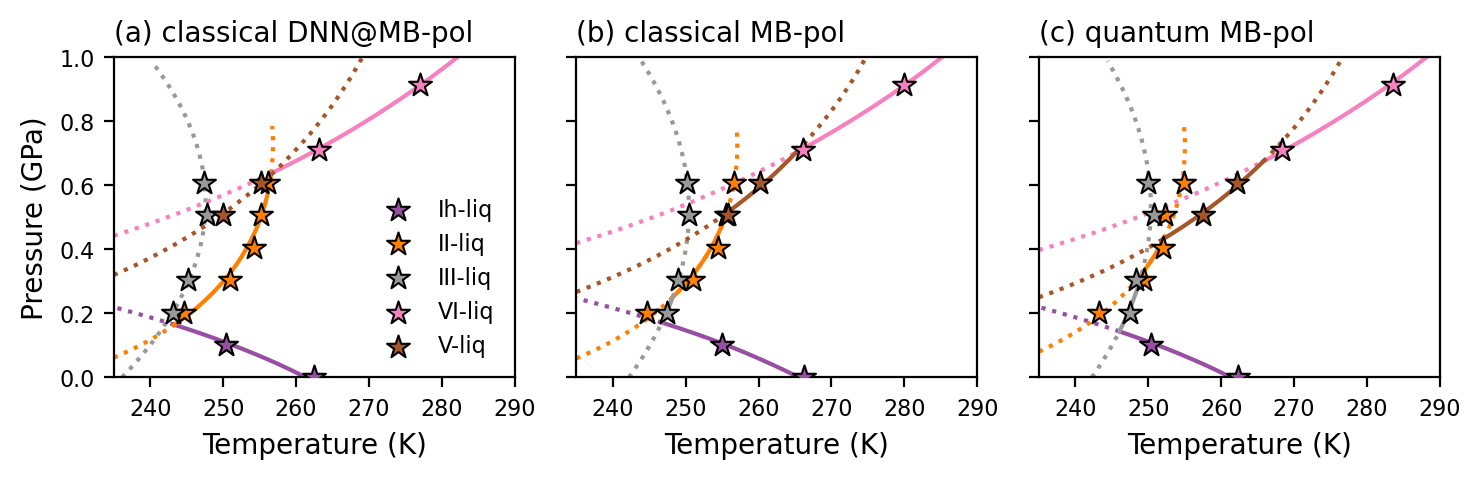

In [218]:
from matplotlib.offsetbox import AnchoredText
liquid_exp=np.loadtxt('ReferenceData/salzman/liquid_extracted.dat')
liquid_exp=liquid_exp[:,::-1]
liquid_exp[:,0]+=273.15
f, axs = plt.subplots(1, 3, sharey=True,figsize=(7.4,2.5))
ax=axs.flatten()

for gl in GibbsLinesDNN.keys():
    
    data2=MeltingPointsDNN[gl]
    data=GibbsLinesDNNAvg[gl]
    label=gl.replace('Ice','').replace('_Liquid','-liq')
    if "Liq" not in gl:
        continue
    ax[0].scatter(data2[:,1],data2[:,0]*atm_to_gpa,color=color_dict_lines[gl],
                        marker='*',edgecolor='k',zorder=10,s=75,linewidth=0.75,label=label)
    if gl in St_lines_NN.keys():
        ax[0].plot(St_lines_NN[gl][:,0],St_lines_NN[gl][:,1]*atm_to_gpa,color=color_dict_lines[gl])
    if gl in Mst_lines_NN.keys():
        for line in Mst_lines_NN[gl]:
            ax[0].plot(line[:,0],line[:,1]*atm_to_gpa,color=color_dict_lines[gl],ls='dotted')
for gl in GibbsLinesClassical.keys():
    data2=MeltingPointsClassical[gl]
    data=GibbsLinesClassicalAvg[gl]
    if "Liq" not in gl:
        continue
    ax[1].scatter(data2[:,1],data2[:,0]*atm_to_gpa,color=color_dict_lines[gl],marker='*',edgecolor='k',zorder=10,s=75,linewidth=0.75)
    if gl in St_lines_Classical.keys():
        ax[1].plot(St_lines_Classical[gl][:,0],St_lines_Classical[gl][:,1]*atm_to_gpa,color=color_dict_lines[gl])
    if gl in Mst_lines_Classical.keys():
        for line in Mst_lines_Classical[gl]:
            ax[1].plot(line[:,0],line[:,1]*atm_to_gpa,color=color_dict_lines[gl],ls='dotted')


for gl in GibbsLinesQuantum.keys():
    data2=MeltingPointsQuantum[gl]
    data=GibbsLinesQuantumAvg[gl]
    if "Liq" not in gl:
        continue
    ax[2].scatter(data2[:,1],data2[:,0]*atm_to_gpa,color=color_dict_lines[gl],marker='*',edgecolor='k',zorder=10,s=75,linewidth=0.75,)
    if gl in St_lines_Quantum.keys():
        ax[2].plot(St_lines_Quantum[gl][:,0],St_lines_Quantum[gl][:,1]*atm_to_gpa,color=color_dict_lines[gl])
    if gl in Mst_lines_Quantum.keys():
        for line in Mst_lines_Quantum[gl]:
            ax[2].plot(line[:,0],line[:,1]*atm_to_gpa,color=color_dict_lines[gl],ls='dotted')
for ai in ax:
    ai.set_xlim((235,290))
    ai.set_ylim((-0.,1))
ax[2].set_xlabel('Temperature (K)')
ax[1].set_xlabel('Temperature (K)')
ax[0].set_xlabel('Temperature (K)')

ax[0].set_ylabel('Pressure (GPa)')
ax[0].legend(frameon=False)   

ax[0].annotate('(a) classical DNN@MB-pol',xy=(0,1.05),xycoords='axes fraction')
ax[1].annotate('(b) classical MB-pol',xy=(0,1.05),xycoords='axes fraction')
ax[2].annotate('(c) quantum MB-pol',xy=(0,1.05),xycoords='axes fraction')

plt.tight_layout()
plt.savefig('figures/coex_lines.pdf')
plt.savefig('figures/fig1.pdf')

plt.savefig('figures/coex_lines.png',dpi=300)


Text(0, 0.5, 'Pressure (GPa)')

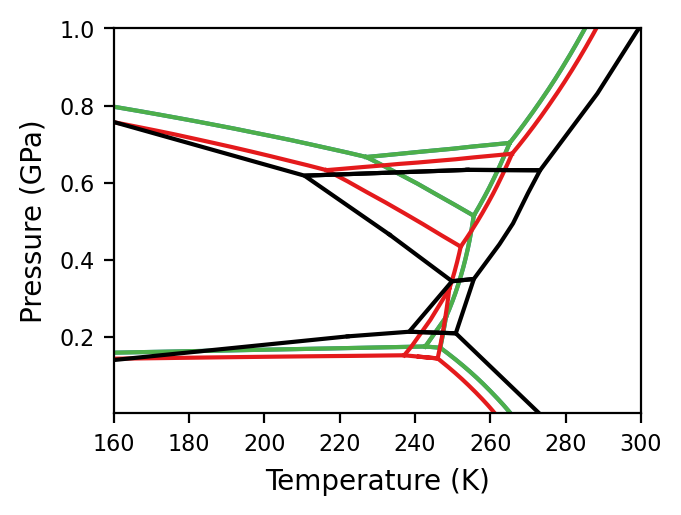

In [219]:
plt.figure(figsize=(3.4,2.5))

for key in St_lines_Classical.keys():    
    plt.plot(St_lines_Classical[key][:,0],St_lines_Classical[key][:,1]*atm_to_gpa,color=colors[0],label='DNN@MB-pol')
for key in St_lines_Classical.keys():    
    plt.plot(St_lines_Classical[key][:,0],St_lines_Classical[key][:,1]*atm_to_gpa,color=colors[1],label='Classical MB-pol')

for key in St_lines_Quantum.keys():    
    plt.plot(St_lines_Quantum[key][:,0],St_lines_Quantum[key][:,1]*atm_to_gpa,color=colors[2],label='Quantum MB-pol')

iceI=pd.read_csv('ReferenceData/salzman/IceI.txt',delimiter='\t',header=None).to_numpy()[:,::-1]    
iceIII=pd.read_csv('ReferenceData/salzman/IceIII.txt',delimiter='\t',header=None).to_numpy()[:,::-1]
iceV=pd.read_csv('ReferenceData/salzman/IceV.txt',delimiter='\t',header=None,na_values='--').to_numpy()[:,::-1]
iceVI=pd.read_csv('ReferenceData/salzman/IceVI.txt',delimiter='\t',header=None).to_numpy()[:,::-1]
iceVII=pd.read_csv('ReferenceData/salzman/Ice VII and VIII.txt',delimiter='\t',header=None).to_numpy()[:,::-1]

iceI[:,::2]+=273.15
iceIII[:,::2]+=273.15
iceV[:,::2]+=273.15
iceVI[:,::2]+=273.15
iceVII[:,::2]+=273.15

iceI[:,1::2]*=9869.23*atm_to_gpa
iceIII[:,1::2]*=9869.23*atm_to_gpa
iceV[:,1::2]*=9869.23*atm_to_gpa
iceVI[:,1::2]*=9869.23*atm_to_gpa
iceVII[:,1::2]*=9869.23*atm_to_gpa

plt.plot(iceI[:,2],iceI[:,3],'k')
plt.plot(iceI[:,4],iceI[:,5],'k')

plt.plot(iceIII[:,0],iceIII[:,1],'k')
plt.plot(iceV[:,0],iceV[:,1],'k')
plt.plot(iceV[:,2],iceV[:,3],'k')

# remove other phases from the experimental phase diagram
keepT=iceVI[:,2]>0
keepP=iceVI[:,3]<1000000*atm_to_gpa
keep=keepT*keepP
plt.plot(iceVI[keep,2],iceVI[keep,3],'k')
plt.plot(iceVI[:,4],iceVI[:,5],'k')
plt.plot(iceVII[:,0],iceVII[:,1],'k')
plt.plot(iceVII[:,2],iceVII[:,3],'k')
plt.xlim((160,300))
plt.ylim((0.001,1))
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (GPa)')


### DNN@MB-pol Area lines

In [171]:
area_lines_nn=dict()
area_lines_nn['Liq']=[]
for key in St_lines_NN.keys():
    if 'Liq' in key:
        area_lines_nn['Liq']+=St_lines_NN[key].tolist()
area_lines_nn['Liq']+=[[300,10000]]+[[300,0]]
area_lines_nn['Liq']=np.array(area_lines_nn['Liq'])

area_lines_nn['II']=[]
for key in St_lines_NN.keys():
    if 'II' in key:
        area_lines_nn['II']+=St_lines_NN[key].tolist()
area_lines_nn['II']=np.array(area_lines_nn['II'])
area_lines_nn['II']=area_lines_nn['II'][np.argsort(area_lines_nn['II'][:,1])]


area_lines_nn['VI']=[]
for key in St_lines_NN.keys():
    if 'VI' in key:
        area_lines_nn['VI']+=St_lines_NN[key].tolist()
area_lines_nn['VI']=np.array(area_lines_nn['VI'])
area_lines_nn['VI']=area_lines_nn['VI'][np.argsort(area_lines_nn['VI'][:,0])]

area_lines_nn['Ih']=[]
for key in St_lines_NN.keys():
    if 'Ih' in key:
        area_lines_nn['Ih']+=St_lines_NN[key].tolist()
area_lines_nn['Ih']=np.array(area_lines_nn['Ih'])
area_lines_nn['Ih']=area_lines_nn['Ih'][np.argsort(area_lines_nn['Ih'][:,0])]



### Classical Area lines 

In [172]:
area_lines_classical=dict()

# Liquid
area_lines_classical['Liq']=[]
for key in St_lines_Classical.keys():
    if 'Liq' in key:
        area_lines_classical['Liq']+=St_lines_Classical[key].tolist()
area_lines_classical['Liq']+=[[400,-5000]]
area_lines_classical['Liq']=np.array(area_lines_classical['Liq'])
area_lines_classical['Liq']=np.array(area_lines_classical['Liq'])[np.argsort(area_lines_classical['Liq'][:,1])]

# Ih
area_lines_classical['Ih']=[]
for key in St_lines_Classical.keys():
    if 'IceIh' in key.split('_'):
        area_lines_classical['Ih']+=St_lines_Classical[key].tolist()
area_lines_classical['Ih']+=[[0,0]]
area_lines_classical['Ih']=np.array(area_lines_classical['Ih'])
area_lines_classical['Ih']=area_lines_classical['Ih'][np.argsort(area_lines_classical['Ih'][:,0])]

#II
area_lines_classical['II']=[]
for key in St_lines_Classical.keys():
    if np.sum(['IceII'==k for k in key.split('_')])>0:
        area_lines_classical['II']+=St_lines_Classical[key].tolist()
area_lines_classical['II']=np.array(area_lines_classical['II'])
area_lines_classical['II']=area_lines_classical['II'][np.argsort(area_lines_classical['II'][:,1])]

#III
area_lines_classical['III']=[]
area_lines_classical['III']+=St_lines_Classical['IceIh_IceIII'].tolist()   
area_lines_classical['III']+=St_lines_Classical['IceII_IceIII'].tolist()        
area_lines_classical['III']+=St_lines_Classical['IceIII_Liquid'][::-1].tolist()  
area_lines_classical['III']=np.array(area_lines_classical['III'])

#V
area_lines_classical['V']=[]
area_lines_classical['V']+=St_lines_Classical['IceV_Liquid'].tolist()   
area_lines_classical['V']+=St_lines_Classical['IceV_IceVI'].tolist()        
area_lines_classical['V']+=St_lines_Classical['IceII_IceV'].tolist()  
area_lines_classical['V']=np.array(area_lines_classical['V'])
area_lines_classical['V']=area_lines_classical['V']#[np.argsort(area_lines_classical['V'][:,0])]

#VI
area_lines_classical['VI']=[]
for key in St_lines_Classical.keys():
    if 'IceVI' in key.split('_'):
        area_lines_classical['VI']+=St_lines_Classical[key].tolist()
area_lines_classical['VI']+=[[100,20000]]
area_lines_classical['VI']=np.array(area_lines_classical['VI'])
area_lines_classical['VI']=area_lines_classical['VI'][np.argsort(area_lines_classical['VI'][:,0])]

### Quantum Area lines 

In [173]:
area_lines_quantum=dict()

# Liquid
area_lines_quantum['Liq']=[]
for key in St_lines_Quantum.keys():
    if 'Liq' in key:
        area_lines_quantum['Liq']+=St_lines_Quantum[key].tolist()
area_lines_quantum['Liq']+=[[400,-5000]]
area_lines_quantum['Liq']=np.array(area_lines_quantum['Liq'])
area_lines_quantum['Liq']=np.array(area_lines_quantum['Liq'])[np.argsort(area_lines_quantum['Liq'][:,1])]

# Ih
area_lines_quantum['Ih']=[]
for key in St_lines_Quantum.keys():
    if 'IceIh' in key.split('_'):
        area_lines_quantum['Ih']+=St_lines_Quantum[key].tolist()
area_lines_quantum['Ih']+=[[0,0]]
area_lines_quantum['Ih']=np.array(area_lines_quantum['Ih'])
area_lines_quantum['Ih']=area_lines_quantum['Ih'][np.argsort(area_lines_quantum['Ih'][:,0])]

#II
area_lines_quantum['II']=[]
for key in St_lines_Quantum.keys():
    if np.sum(['IceII'==k for k in key.split('_')])>0:
        area_lines_quantum['II']+=St_lines_Quantum[key].tolist()
area_lines_quantum['II']=np.array(area_lines_quantum['II'])
area_lines_quantum['II']=area_lines_quantum['II'][np.argsort(area_lines_quantum['II'][:,1])]

#III
area_lines_quantum['III']=[]
area_lines_quantum['III']+=St_lines_Quantum['IceIh_IceIII'].tolist()   
area_lines_quantum['III']+=St_lines_Quantum['IceII_IceIII'].tolist()        
area_lines_quantum['III']+=St_lines_Quantum['IceIII_Liquid'][::-1].tolist()  
area_lines_quantum['III']=np.array(area_lines_quantum['III'])
#area_lines_quantum['III']=area_lines_quantum['V']#[np.argsort(area_lines_quantum['V'][:,0])]



#V
area_lines_quantum['V']=[]
area_lines_quantum['V']+=St_lines_Quantum['IceV_Liquid'].tolist()   
area_lines_quantum['V']+=St_lines_Quantum['IceV_IceVI'].tolist()        
area_lines_quantum['V']+=St_lines_Quantum['IceII_IceV'].tolist()  
area_lines_quantum['V']=np.array(area_lines_quantum['V'])
area_lines_quantum['V']=area_lines_quantum['V']#[np.argsort(area_lines_quantum['V'][:,0])]

#VI
area_lines_quantum['VI']=[]
for key in St_lines_Quantum.keys():
    if 'IceVI' in key.split('_'):
        area_lines_quantum['VI']+=St_lines_Quantum[key].tolist()
area_lines_quantum['VI']+=[[100,20000]]

area_lines_quantum['VI']=np.array(area_lines_quantum['VI'])
area_lines_quantum['VI']=area_lines_quantum['VI'][np.argsort(area_lines_quantum['VI'][:,0])]

### Experimental area lines 

In [174]:
area_lines_experimental=dict()
area_lines_experimental['Ih']=np.loadtxt('ReferenceData/ExpAreaLines/Ih.dat')
area_lines_experimental['II']=np.loadtxt('ReferenceData/ExpAreaLines/II.dat')
area_lines_experimental['III']=np.loadtxt('ReferenceData/ExpAreaLines/III.dat')
area_lines_experimental['V']=np.loadtxt('ReferenceData/ExpAreaLines/V.dat')
area_lines_experimental['VI']=np.loadtxt('ReferenceData/ExpAreaLines/VI.dat')
area_lines_experimental['Liq']=np.loadtxt('ReferenceData/ExpAreaLines/Liq.dat')


/tmp/ipykernel_7202/2419410142.py:45: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[1].annotate('III', xy=(246, 0.20),color=color_dict['III'], xycoords='data',
/tmp/ipykernel_7202/2419410142.py:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[2].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',


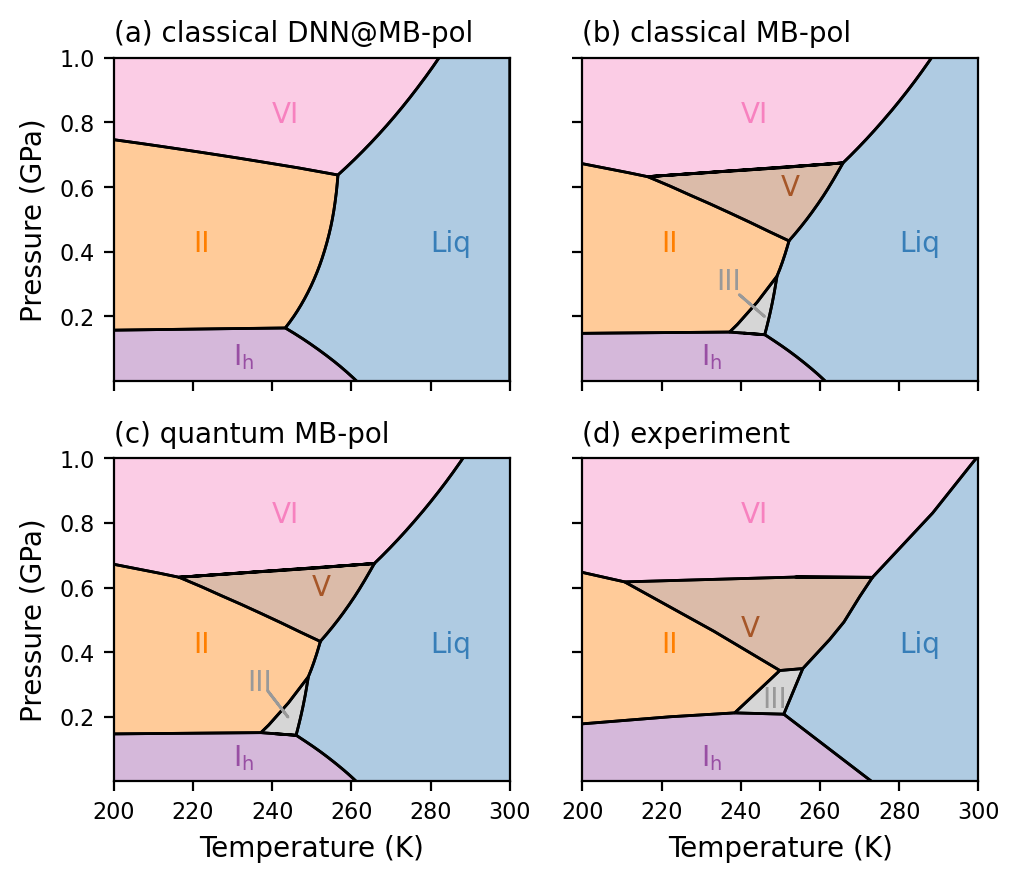

In [175]:
fig,ax=plt.subplots(2,2,figsize=(5.2,4.5),sharey=True,sharex=True)

axs=ax.flatten()
for j, al in enumerate(area_lines_nn.keys()):
    
    axs[0].fill(area_lines_nn[al][:,0],area_lines_nn[al][:,1]*atm_to_gpa,alpha=0.4,lw=0,color=color_dict[al])
    axs[0].plot(area_lines_nn[al][:,0],area_lines_nn[al][:,1]*atm_to_gpa,lw=1,color='k')


for j, al in enumerate(area_lines_classical.keys()):
    axs[1].fill(area_lines_classical[al][:,0],area_lines_classical[al][:,1]*atm_to_gpa,alpha=0.4,lw=0,color=color_dict[al])
    axs[1].plot(area_lines_classical[al][:,0],area_lines_classical[al][:,1]*atm_to_gpa,lw=1,color='k')

for j, al in enumerate(area_lines_quantum.keys()):
    axs[2].fill(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,alpha=0.4,lw=0,color=color_dict[al])
    axs[2].plot(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,lw=1,color='k')

for j, al in enumerate(area_lines_experimental.keys()):
    axs[3].fill(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[3].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='k')
    

for ax in axs:
    ax.set_xlim((200,300))
    ax.set_ylim((0.001,1))
axs[2].set_xlabel('Temperature (K)')
axs[3].set_xlabel('Temperature (K)')

axs[0].set_ylabel('Pressure (GPa)')
axs[2].set_ylabel('Pressure (GPa)')

axs[0].annotate('(a) classical DNN@MB-pol',xy=(0,1.05),xycoords='axes fraction')
axs[1].annotate('(b) classical MB-pol',xy=(0,1.05),xycoords='axes fraction')
axs[2].annotate('(c) quantum MB-pol',xy=(0,1.05),xycoords='axes fraction')
axs[3].annotate('(d) experiment',xy=(0,1.05),xycoords='axes fraction')
axs[0].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[0].annotate('II',xy=(220,0.4),color=color_dict['II'])
axs[0].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[0].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[1].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[1].annotate('II',xy=(220,0.4),color=color_dict['II'])
axs[1].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[1].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[1].annotate('V',xy=(250,0.575),color=color_dict['V'])
axs[1].annotate('III', xy=(246, 0.20),color=color_dict['III'], xycoords='data',
            xytext=(240, 0.35),
            arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),
            horizontalalignment='right', verticalalignment='top',
            )
axs[2].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[2].annotate('II',xy=(220,0.4),color=color_dict['II'])
axs[2].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[2].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[2].annotate('V',xy=(250,0.575),color=color_dict['V'])
axs[2].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',
            xytext=(240, 0.35),
            arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),
            horizontalalignment='right', verticalalignment='top',
            )
axs[3].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[3].annotate('II',xy=(220,0.4),color=color_dict['II'])
axs[3].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[3].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[3].annotate('V',xy=(240, 0.45),color=color_dict['V'])
axs[3].annotate('III', xy=(245.5, 0.23),color=color_dict['III'])

plt.tight_layout()
plt.savefig('figures/phase_diagram.pdf')
plt.savefig('figures/phase_diagram.png',dpi=300)
plt.savefig('figures/fig2.pdf')


### Load other models

In [176]:
def PolyQuad(T,dat):
 
    
    z = np.polyfit(dat[:,0], dat[:,1], 2)
    fn = np.poly1d(z)
    return np.vstack((T,fn(T))).T

### Zhang

In [177]:
area_lines_zhang=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_Zhang/Liq_Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_V=np.loadtxt('ReferenceData/PD_Zhang/Liq_V.dat')
Liq_V=PolyQuad(np.linspace(Liq_V[:,0].min(),Liq_V[:,0].max(),200),Liq_V)

Ih_II=np.loadtxt('ReferenceData/PD_Zhang/Ih_II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_V=np.loadtxt('ReferenceData/PD_Zhang/Ih_V.dat')

II_V=np.loadtxt('ReferenceData/PD_Zhang/II_V.dat')
II_V=PolyQuad(np.linspace(II_V[:,0].min(),II_V[:,0].max(),200),II_V)

V_VI=np.loadtxt('ReferenceData/PD_Zhang/V_VI.dat')
II_VI=np.loadtxt('ReferenceData/PD_Zhang/II_VI.dat')
II_VI=PolyQuad(np.linspace(II_VI[:,0].min(),II_VI[:,0].max(),200),II_VI)

Liq_VI=np.loadtxt('ReferenceData/PD_Zhang/Liq_VI.dat')



area_lines_zhang['Liq']=Liq_Ih.tolist()
area_lines_zhang['Liq']+=Liq_V.tolist()

area_lines_zhang['Liq']=np.array(area_lines_zhang['Liq'])
area_lines_zhang['Liq']=area_lines_zhang['Liq'][area_lines_zhang['Liq'][:,1].argsort()]

#Ih
area_lines_zhang['Ih']=Liq_Ih.tolist()
area_lines_zhang['Ih']+=Ih_V.tolist()
area_lines_zhang['Ih']+=Ih_II.tolist()
area_lines_zhang['Ih']=np.array(area_lines_zhang['Ih'])
area_lines_zhang['Ih']=area_lines_zhang['Ih'][area_lines_zhang['Ih'][:,0].argsort()]

#II
area_lines_zhang['II']=Ih_II.tolist()
area_lines_zhang['II']+=II_V.tolist()
area_lines_zhang['II']+=II_VI.tolist()

area_lines_zhang['II']=np.array(area_lines_zhang['II'])
area_lines_zhang['II']=area_lines_zhang['II'][area_lines_zhang['II'][:,1].argsort()]

#V
area_lines_zhang['V']=Liq_V.tolist()
area_lines_zhang['V']+=V_VI.tolist()[::-1]
area_lines_zhang['V']+=II_V.tolist()
area_lines_zhang['V']+=Ih_V.tolist()
area_lines_zhang['V']=np.array(area_lines_zhang['V'])

#VI
area_lines_zhang['VI']=II_VI.tolist()
area_lines_zhang['VI']+=V_VI.tolist()
area_lines_zhang['VI']+=Liq_VI.tolist()
area_lines_zhang['VI']=np.array(area_lines_zhang['VI'])



### Reinhardt

In [178]:
area_lines_reinhardt=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_Reinhardt2/Liq_Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_V=np.loadtxt('ReferenceData/PD_Reinhardt2/Liq_V.dat')
Liq_V=PolyQuad(np.linspace(Liq_V[:,0].min(),400,200),Liq_V)

Ih_II=np.loadtxt('ReferenceData/PD_Reinhardt2/Ih_II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_V=np.loadtxt('ReferenceData/PD_Reinhardt2/Ih_V.dat')

II_V=np.loadtxt('ReferenceData/PD_Reinhardt2/II_V.dat')
II_V=PolyQuad(np.linspace(200,II_V[:,0].max(),200),II_V)


area_lines_reinhardt['Liq']=Liq_Ih.tolist()
area_lines_reinhardt['Liq']+=Liq_V.tolist()

area_lines_reinhardt['Liq']=np.array(area_lines_reinhardt['Liq'])
area_lines_reinhardt['Liq']=area_lines_reinhardt['Liq'][area_lines_reinhardt['Liq'][:,1].argsort()]

#Ih
area_lines_reinhardt['Ih']=Liq_Ih.tolist()
area_lines_reinhardt['Ih']+=Ih_V.tolist()
area_lines_reinhardt['Ih']+=Ih_II.tolist()
area_lines_reinhardt['Ih']+=[[0,0]]
area_lines_reinhardt['Ih']=np.array(area_lines_reinhardt['Ih'])
area_lines_reinhardt['Ih']=area_lines_reinhardt['Ih'][area_lines_reinhardt['Ih'][:,0].argsort()]

#II
area_lines_reinhardt['II']=Ih_II.tolist()
area_lines_reinhardt['II']+=II_V.tolist()
area_lines_reinhardt['II']=np.array(area_lines_reinhardt['II'])
area_lines_reinhardt['II']=area_lines_reinhardt['II'][area_lines_reinhardt['II'][:,1].argsort()]

#V
area_lines_reinhardt['V']=Liq_V.tolist()
area_lines_reinhardt['V']+=Ih_V.tolist()
area_lines_reinhardt['V']+=II_V.tolist()
area_lines_reinhardt['V']+=[[0,12000]]
area_lines_reinhardt['V']=np.array(area_lines_reinhardt['V'])
area_lines_reinhardt['V']=area_lines_reinhardt['V'][area_lines_reinhardt['V'][:,0].argsort()]

### Bride

In [179]:
area_lines_bride=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_Bride/Liq_Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_III=np.loadtxt('ReferenceData/PD_Bride/Liq_III.dat')

Liq_V=np.loadtxt('ReferenceData/PD_Bride/Liq_V.dat')
Liq_VI=np.loadtxt('ReferenceData/PD_Bride/Liq_VI.dat')

Ih_II=np.loadtxt('ReferenceData/PD_Bride/Ih_II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_III=np.loadtxt('ReferenceData/PD_Bride/Ih_III.dat')

II_VI=np.loadtxt('ReferenceData/PD_Bride/II_VI.dat')
II_V=np.loadtxt('ReferenceData/PD_Bride/II_V.dat')
II_III=np.loadtxt('ReferenceData/PD_Bride/II_III.dat')

III_V=np.loadtxt('ReferenceData/PD_Bride/III_V.dat')

V_VI=np.loadtxt('ReferenceData/PD_Bride/V_VI.dat')

area_lines_bride['Liq']=[[500,0]]
area_lines_bride['Liq']+=Liq_Ih.tolist()
area_lines_bride['Liq']+=Liq_III.tolist()
area_lines_bride['Liq']+=Liq_V.tolist()
area_lines_bride['Liq']+=Liq_VI.tolist()
area_lines_bride['Liq']+=[[500,15000]]

area_lines_bride['Liq']=np.array(area_lines_bride['Liq'])
area_lines_bride['Liq']=area_lines_bride['Liq'][area_lines_bride['Liq'][:,1].argsort()]

#Ih
area_lines_bride['Ih']=Liq_Ih.tolist()
area_lines_bride['Ih']+=Ih_III.tolist()
area_lines_bride['Ih']+=Ih_II.tolist()
area_lines_bride['Ih']+=[[0,0]]
area_lines_bride['Ih']=np.array(area_lines_bride['Ih'])
area_lines_bride['Ih']=area_lines_bride['Ih'][area_lines_bride['Ih'][:,0].argsort()]

#II
area_lines_bride['II']=Ih_II.tolist()
area_lines_bride['II']+=II_III.tolist()
area_lines_bride['II']+=II_V.tolist()
area_lines_bride['II']+=II_VI.tolist()
area_lines_bride['II']=np.array(area_lines_bride['II'])
area_lines_bride['II']=area_lines_bride['II'][area_lines_bride['II'][:,1].argsort()]

#III
area_lines_bride['III']=Ih_III.tolist()
area_lines_bride['III']+=Liq_III.tolist()
area_lines_bride['III']+=III_V.tolist()[::-1]
area_lines_bride['III']+=II_III.tolist()[::-1]
area_lines_bride['III']=np.array(area_lines_bride['III'])

#V
area_lines_bride['V']=III_V.tolist()
area_lines_bride['V']+=Liq_V.tolist()
area_lines_bride['V']+=V_VI.tolist()[::-1]
area_lines_bride['V']+=II_V.tolist()[::-1]
area_lines_bride['V']=np.array(area_lines_bride['V'])

#VI
area_lines_bride['VI']=[[10,20000]]
area_lines_bride['VI']+=II_VI.tolist()
area_lines_bride['VI']+=V_VI.tolist()
area_lines_bride['VI']+=Liq_VI.tolist()
area_lines_bride['VI']=np.array(area_lines_bride['VI'])


### TIP4P/2005

In [180]:
area_lines_tip4p_2005=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_conde2013determining/Liq-Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_III=np.loadtxt('ReferenceData/PD_conde2013determining/Liq-III.dat')

Liq_V=np.loadtxt('ReferenceData/PD_conde2013determining/Liq-V.dat')
Liq_VI=np.loadtxt('ReferenceData/PD_conde2013determining/Liq-VI.dat')

Ih_II=np.loadtxt('ReferenceData/PD_conde2013determining/Ih-II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_III=np.loadtxt('ReferenceData/PD_conde2013determining/Ih-III.dat')

II_V=np.loadtxt('ReferenceData/PD_conde2013determining/II-V.dat')
II_III=np.loadtxt('ReferenceData/PD_conde2013determining/II-III.dat')

III_V=np.loadtxt('ReferenceData/PD_conde2013determining/III-V.dat')

V_VI=np.loadtxt('ReferenceData/PD_conde2013determining/V-VI.dat')
V_VI=PolyQuad(np.linspace(150,V_VI[:,0].max(),200),V_VI)

area_lines_tip4p_2005['Liq']=[[500,0]]
area_lines_tip4p_2005['Liq']+=Liq_Ih.tolist()
area_lines_tip4p_2005['Liq']+=Liq_III.tolist()
area_lines_tip4p_2005['Liq']+=Liq_V.tolist()
area_lines_tip4p_2005['Liq']+=Liq_VI.tolist()
area_lines_tip4p_2005['Liq']+=[[500,1.5]]

area_lines_tip4p_2005['Liq']=np.array(area_lines_tip4p_2005['Liq'])
area_lines_tip4p_2005['Liq']=area_lines_tip4p_2005['Liq'][area_lines_tip4p_2005['Liq'][:,1].argsort()]

#Ih
area_lines_tip4p_2005['Ih']=Liq_Ih.tolist()
area_lines_tip4p_2005['Ih']+=Ih_III.tolist()
area_lines_tip4p_2005['Ih']+=Ih_II.tolist()
area_lines_tip4p_2005['Ih']=np.array(area_lines_tip4p_2005['Ih'])
area_lines_tip4p_2005['Ih']=area_lines_tip4p_2005['Ih'][area_lines_tip4p_2005['Ih'][:,0].argsort()]

#II
area_lines_tip4p_2005['II']=Ih_II.tolist()
area_lines_tip4p_2005['II']+=II_III.tolist()
area_lines_tip4p_2005['II']+=II_V.tolist()
area_lines_tip4p_2005['II']+=II_VI.tolist()
area_lines_tip4p_2005['II']=np.array(area_lines_tip4p_2005['II'])
area_lines_tip4p_2005['II']=area_lines_tip4p_2005['II'][area_lines_tip4p_2005['II'][:,1].argsort()]

#III
area_lines_tip4p_2005['III']=Ih_III.tolist()
area_lines_tip4p_2005['III']+=Liq_III.tolist()
area_lines_tip4p_2005['III']+=III_V.tolist()[::-1]
area_lines_tip4p_2005['III']+=II_III.tolist()[::-1]
area_lines_tip4p_2005['III']=np.array(area_lines_tip4p_2005['III'])

#V
area_lines_tip4p_2005['V']=III_V.tolist()
area_lines_tip4p_2005['V']+=Liq_V.tolist()
area_lines_tip4p_2005['V']+=V_VI.tolist()[::-1]
area_lines_tip4p_2005['V']+=II_V.tolist()#[::-1]
area_lines_tip4p_2005['V']=np.array(area_lines_tip4p_2005['V'])

#VI
area_lines_tip4p_2005['VI']=[[0,2]]
area_lines_tip4p_2005['VI']+=V_VI.tolist()
area_lines_tip4p_2005['VI']+=Liq_VI.tolist()
area_lines_tip4p_2005['VI']+=[[400,2]]
area_lines_tip4p_2005['VI']=np.array(area_lines_tip4p_2005['VI'])
area_lines_tip4p_2005['VI']=area_lines_tip4p_2005['VI'][area_lines_tip4p_2005['VI'][:,0].argsort()]


### TIP4P/2005 abascal2005general

In [181]:
area_lines_abascal2005general=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_abascal2005general/Liq-Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_III=np.loadtxt('ReferenceData/PD_abascal2005general/Liq-III.dat')

Liq_V=np.loadtxt('ReferenceData/PD_abascal2005general/Liq-V.dat')
Liq_VI=np.loadtxt('ReferenceData/PD_abascal2005general/Liq-VI.dat')

Ih_II=np.loadtxt('ReferenceData/PD_abascal2005general/Ih-II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_III=np.loadtxt('ReferenceData/PD_abascal2005general/Ih-III.dat')

II_V=np.loadtxt('ReferenceData/PD_abascal2005general/II-V.dat')
II_III=np.loadtxt('ReferenceData/PD_abascal2005general/II-III.dat')

III_V=np.loadtxt('ReferenceData/PD_abascal2005general/III-V.dat')

V_VI=np.loadtxt('ReferenceData/PD_abascal2005general/V-VI.dat')
V_VI=PolyQuad(np.linspace(150,V_VI[:,0].max(),200),V_VI)

area_lines_abascal2005general['Liq']=[[500,0]]
area_lines_abascal2005general['Liq']+=Liq_Ih.tolist()
area_lines_abascal2005general['Liq']+=Liq_III.tolist()
area_lines_abascal2005general['Liq']+=Liq_V.tolist()
area_lines_abascal2005general['Liq']+=Liq_VI.tolist()
area_lines_abascal2005general['Liq']+=[[500,1.5]]

area_lines_abascal2005general['Liq']=np.array(area_lines_abascal2005general['Liq'])
area_lines_abascal2005general['Liq']=area_lines_abascal2005general['Liq'][area_lines_abascal2005general['Liq'][:,1].argsort()]

#Ih
area_lines_abascal2005general['Ih']=Liq_Ih.tolist()
area_lines_abascal2005general['Ih']+=Ih_III.tolist()
area_lines_abascal2005general['Ih']+=Ih_II.tolist()
area_lines_abascal2005general['Ih']=np.array(area_lines_abascal2005general['Ih'])
area_lines_abascal2005general['Ih']=area_lines_abascal2005general['Ih'][area_lines_abascal2005general['Ih'][:,0].argsort()]

#II
area_lines_abascal2005general['II']=Ih_II.tolist()
area_lines_abascal2005general['II']+=II_III.tolist()
area_lines_abascal2005general['II']+=II_V.tolist()
area_lines_abascal2005general['II']+=II_VI.tolist()
area_lines_abascal2005general['II']=np.array(area_lines_abascal2005general['II'])
area_lines_abascal2005general['II']=area_lines_abascal2005general['II'][area_lines_abascal2005general['II'][:,1].argsort()]

#III
area_lines_abascal2005general['III']=Ih_III.tolist()
area_lines_abascal2005general['III']+=Liq_III.tolist()
area_lines_abascal2005general['III']+=III_V.tolist()[::-1]
area_lines_abascal2005general['III']+=II_III.tolist()[::-1]
area_lines_abascal2005general['III']=np.array(area_lines_abascal2005general['III'])

#V
area_lines_abascal2005general['V']=III_V.tolist()
area_lines_abascal2005general['V']+=Liq_V.tolist()
area_lines_abascal2005general['V']+=V_VI.tolist()[::-1]
area_lines_abascal2005general['V']+=II_V.tolist()#[::-1]
area_lines_abascal2005general['V']=np.array(area_lines_abascal2005general['V'])

#VI
area_lines_abascal2005general['VI']=[[0,2]]
area_lines_abascal2005general['VI']+=V_VI.tolist()
area_lines_abascal2005general['VI']+=Liq_VI.tolist()
area_lines_abascal2005general['VI']+=[[400,2]]
area_lines_abascal2005general['VI']=np.array(area_lines_abascal2005general['VI'])
area_lines_abascal2005general['VI']=area_lines_abascal2005general['VI'][area_lines_abascal2005general['VI'][:,0].argsort()]


### TIP4P/Ice

In [182]:
area_lines_tip4p_ice=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_TIP4P-ICE/Liq_Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_III=np.loadtxt('ReferenceData/PD_TIP4P-ICE/Liq_III.dat')

Liq_V=np.loadtxt('ReferenceData/PD_TIP4P-ICE/Liq_V.dat')
Liq_VI=np.loadtxt('ReferenceData/PD_TIP4P-ICE/Liq_VI.dat')

Ih_II=np.loadtxt('ReferenceData/PD_TIP4P-ICE/Ih_II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_III=np.loadtxt('ReferenceData/PD_TIP4P-ICE/Ih_III.dat')

II_V=np.loadtxt('ReferenceData/PD_TIP4P-ICE/II_V.dat')
II_III=np.loadtxt('ReferenceData/PD_TIP4P-ICE/II_III.dat')

III_V=np.loadtxt('ReferenceData/PD_TIP4P-ICE/III_V.dat')

V_VI=np.loadtxt('ReferenceData/PD_TIP4P-ICE/V_VI.dat')
V_VI=PolyQuad(np.linspace(150,V_VI[:,0].max(),200),V_VI)

area_lines_tip4p_ice['Liq']=[[500,0]]
area_lines_tip4p_ice['Liq']+=Liq_Ih.tolist()
area_lines_tip4p_ice['Liq']+=Liq_III.tolist()
area_lines_tip4p_ice['Liq']+=Liq_V.tolist()
area_lines_tip4p_ice['Liq']+=Liq_VI.tolist()
area_lines_tip4p_ice['Liq']+=[[500,1.5]]

area_lines_tip4p_ice['Liq']=np.array(area_lines_tip4p_ice['Liq'])
area_lines_tip4p_ice['Liq']=area_lines_tip4p_ice['Liq'][area_lines_tip4p_ice['Liq'][:,1].argsort()]

#Ih
area_lines_tip4p_ice['Ih']=Liq_Ih.tolist()
area_lines_tip4p_ice['Ih']+=Ih_III.tolist()
area_lines_tip4p_ice['Ih']+=Ih_II.tolist()
area_lines_tip4p_ice['Ih']=np.array(area_lines_tip4p_ice['Ih'])
area_lines_tip4p_ice['Ih']=area_lines_tip4p_ice['Ih'][area_lines_tip4p_ice['Ih'][:,0].argsort()]

#II
area_lines_tip4p_ice['II']=Ih_II.tolist()
area_lines_tip4p_ice['II']+=II_III.tolist()
area_lines_tip4p_ice['II']+=II_V.tolist()
area_lines_tip4p_ice['II']+=II_VI.tolist()
area_lines_tip4p_ice['II']=np.array(area_lines_tip4p_ice['II'])
area_lines_tip4p_ice['II']=area_lines_tip4p_ice['II'][area_lines_tip4p_ice['II'][:,1].argsort()]

#III
area_lines_tip4p_ice['III']=Ih_III.tolist()
area_lines_tip4p_ice['III']+=Liq_III.tolist()
area_lines_tip4p_ice['III']+=III_V.tolist()[::-1]
area_lines_tip4p_ice['III']+=II_III.tolist()[::-1]
area_lines_tip4p_ice['III']=np.array(area_lines_tip4p_ice['III'])

#V
area_lines_tip4p_ice['V']=III_V.tolist()
area_lines_tip4p_ice['V']+=Liq_V.tolist()
area_lines_tip4p_ice['V']+=V_VI.tolist()[::-1]
area_lines_tip4p_ice['V']+=II_V.tolist()#[::-1]
area_lines_tip4p_ice['V']=np.array(area_lines_tip4p_ice['V'])

#VI
area_lines_tip4p_ice['VI']=[[0,2]]
area_lines_tip4p_ice['VI']+=II_VI.tolist()
area_lines_tip4p_ice['VI']+=V_VI.tolist()
area_lines_tip4p_ice['VI']+=Liq_VI.tolist()
area_lines_tip4p_ice['VI']=np.array(area_lines_tip4p_ice['VI'])
area_lines_tip4p_ice['VI']=area_lines_tip4p_ice['VI'][area_lines_tip4p_ice['VI'][:,0].argsort()]




### iAmoeba

In [183]:
area_lines_iamoeba=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_iAmoeba/Liq_Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_III=np.loadtxt('ReferenceData/PD_iAmoeba/Liq_III.dat')

Liq_V=np.loadtxt('ReferenceData/PD_iAmoeba/Liq_V.dat')
Liq_VI=np.loadtxt('ReferenceData/PD_iAmoeba/Liq_VI.dat')

Ih_II=np.loadtxt('ReferenceData/PD_iAmoeba/Ih_II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_III=np.loadtxt('ReferenceData/PD_iAmoeba/Ih_III.dat')

II_V=np.loadtxt('ReferenceData/PD_iAmoeba/II_V.dat')
II_III=np.loadtxt('ReferenceData/PD_iAmoeba/II_III.dat')

III_V=np.loadtxt('ReferenceData/PD_iAmoeba/III_V.dat')

V_VI=np.loadtxt('ReferenceData/PD_iAmoeba/V_VI.dat')
V_VI=PolyQuad(np.linspace(150,V_VI[:,0].max(),200),V_VI)

area_lines_iamoeba['Liq']=[[500,0]]
area_lines_iamoeba['Liq']+=Liq_Ih.tolist()
area_lines_iamoeba['Liq']+=Liq_III.tolist()
area_lines_iamoeba['Liq']+=Liq_V.tolist()
area_lines_iamoeba['Liq']+=Liq_VI.tolist()
area_lines_iamoeba['Liq']+=[[500,1.5]]

area_lines_iamoeba['Liq']=np.array(area_lines_iamoeba['Liq'])
area_lines_iamoeba['Liq']=area_lines_iamoeba['Liq'][area_lines_iamoeba['Liq'][:,1].argsort()]

#Ih
area_lines_iamoeba['Ih']=Liq_Ih.tolist()
area_lines_iamoeba['Ih']+=Ih_III.tolist()
area_lines_iamoeba['Ih']+=Ih_II.tolist()
area_lines_iamoeba['Ih']=np.array(area_lines_iamoeba['Ih'])
area_lines_iamoeba['Ih']=area_lines_iamoeba['Ih'][area_lines_iamoeba['Ih'][:,0].argsort()]

#II
area_lines_iamoeba['II']=Ih_II.tolist()
area_lines_iamoeba['II']+=II_III.tolist()
area_lines_iamoeba['II']+=II_V.tolist()
area_lines_iamoeba['II']=np.array(area_lines_iamoeba['II'])
area_lines_iamoeba['II']=area_lines_iamoeba['II'][area_lines_iamoeba['II'][:,1].argsort()]

#III
area_lines_iamoeba['III']=Ih_III.tolist()
area_lines_iamoeba['III']+=Liq_III.tolist()
area_lines_iamoeba['III']+=III_V.tolist()[::-1]
area_lines_iamoeba['III']+=II_III.tolist()[::-1]
area_lines_iamoeba['III']=np.array(area_lines_iamoeba['III'])

#V
area_lines_iamoeba['V']=III_V.tolist()
area_lines_iamoeba['V']+=Liq_V.tolist()
area_lines_iamoeba['V']+=V_VI.tolist()[::-1]
area_lines_iamoeba['V']+=II_V.tolist()
area_lines_iamoeba['V']=np.array(area_lines_iamoeba['V'])

### TIP4P/Ice Bore et al.

In [184]:
area_lines_tip4p_ice_bore=dict()

# Load lines
Liq_Ih=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/Liq_Ih.dat')
Liq_Ih=PolyQuad(np.linspace(Liq_Ih[:,0].min(),400,200),Liq_Ih)

Liq_III=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/Liq_III.dat')

Liq_V=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/Liq_V.dat')
Liq_VI=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/Liq_VI.dat')

Ih_II=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/Ih_II.dat')
Ih_II=PolyQuad(np.linspace(100,Ih_II[:,0].max(),200),Ih_II)

Ih_III=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/Ih_III.dat')

II_VI=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/II_VI.dat')
II_V=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/II_V.dat')
II_III=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/II_III.dat')

III_V=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/III_V.dat')

V_VI=np.loadtxt('ReferenceData/PD_TIP4P-ICE-BORE/V_VI.dat')

area_lines_tip4p_ice_bore['Liq']=[[500,0]]
area_lines_tip4p_ice_bore['Liq']+=Liq_Ih.tolist()
area_lines_tip4p_ice_bore['Liq']+=Liq_III.tolist()
area_lines_tip4p_ice_bore['Liq']+=Liq_V.tolist()
area_lines_tip4p_ice_bore['Liq']+=Liq_VI.tolist()
area_lines_tip4p_ice_bore['Liq']+=[[500,15000]]

area_lines_tip4p_ice_bore['Liq']=np.array(area_lines_tip4p_ice_bore['Liq'])
area_lines_tip4p_ice_bore['Liq']=area_lines_tip4p_ice_bore['Liq'][area_lines_tip4p_ice_bore['Liq'][:,1].argsort()]

#Ih
area_lines_tip4p_ice_bore['Ih']=Liq_Ih.tolist()
area_lines_tip4p_ice_bore['Ih']+=Ih_III.tolist()
area_lines_tip4p_ice_bore['Ih']+=Ih_II.tolist()
area_lines_tip4p_ice_bore['Ih']+=[[0,0]]
area_lines_tip4p_ice_bore['Ih']=np.array(area_lines_tip4p_ice_bore['Ih'])
area_lines_tip4p_ice_bore['Ih']=area_lines_tip4p_ice_bore['Ih'][area_lines_tip4p_ice_bore['Ih'][:,0].argsort()]

#II
area_lines_tip4p_ice_bore['II']=Ih_II.tolist()
area_lines_tip4p_ice_bore['II']+=II_III.tolist()
area_lines_tip4p_ice_bore['II']+=II_V.tolist()
area_lines_tip4p_ice_bore['II']+=II_VI.tolist()
area_lines_tip4p_ice_bore['II']=np.array(area_lines_tip4p_ice_bore['II'])
area_lines_tip4p_ice_bore['II']=area_lines_tip4p_ice_bore['II'][area_lines_tip4p_ice_bore['II'][:,1].argsort()]

#III
area_lines_tip4p_ice_bore['III']=Ih_III.tolist()
area_lines_tip4p_ice_bore['III']+=Liq_III.tolist()
area_lines_tip4p_ice_bore['III']+=III_V.tolist()[::-1]
area_lines_tip4p_ice_bore['III']+=II_III.tolist()[::-1]
area_lines_tip4p_ice_bore['III']=np.array(area_lines_tip4p_ice_bore['III'])

#V
area_lines_tip4p_ice_bore['V']=III_V.tolist()
area_lines_tip4p_ice_bore['V']+=Liq_V.tolist()
area_lines_tip4p_ice_bore['V']+=V_VI.tolist()[::-1]
area_lines_tip4p_ice_bore['V']+=II_V.tolist()[::-1]
area_lines_tip4p_ice_bore['V']=np.array(area_lines_tip4p_ice_bore['V'])

#VI
area_lines_tip4p_ice_bore['VI']=[[10,20000]]
area_lines_tip4p_ice_bore['VI']+=II_VI.tolist()
area_lines_tip4p_ice_bore['VI']+=V_VI.tolist()
area_lines_tip4p_ice_bore['VI']+=Liq_VI.tolist()
area_lines_tip4p_ice_bore['VI']=np.array(area_lines_tip4p_ice_bore['VI'])


/tmp/ipykernel_7202/3013326185.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].annotate('II',xy=(210,0.325),color=color_dict['II'], xycoords='data',
/tmp/ipykernel_7202/3013326185.py:88: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[0].annotate('III', xy=(230, 0.325),color=color_dict['III'], xycoords='data',
/tmp/ipykernel_7202/3013326185.py:97: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[1].annotate('V',xy=(250,0.825),color=color_dict['V'],xycoords='data',
/tmp/ipykernel_7202/3013326185.py:111: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[5].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',


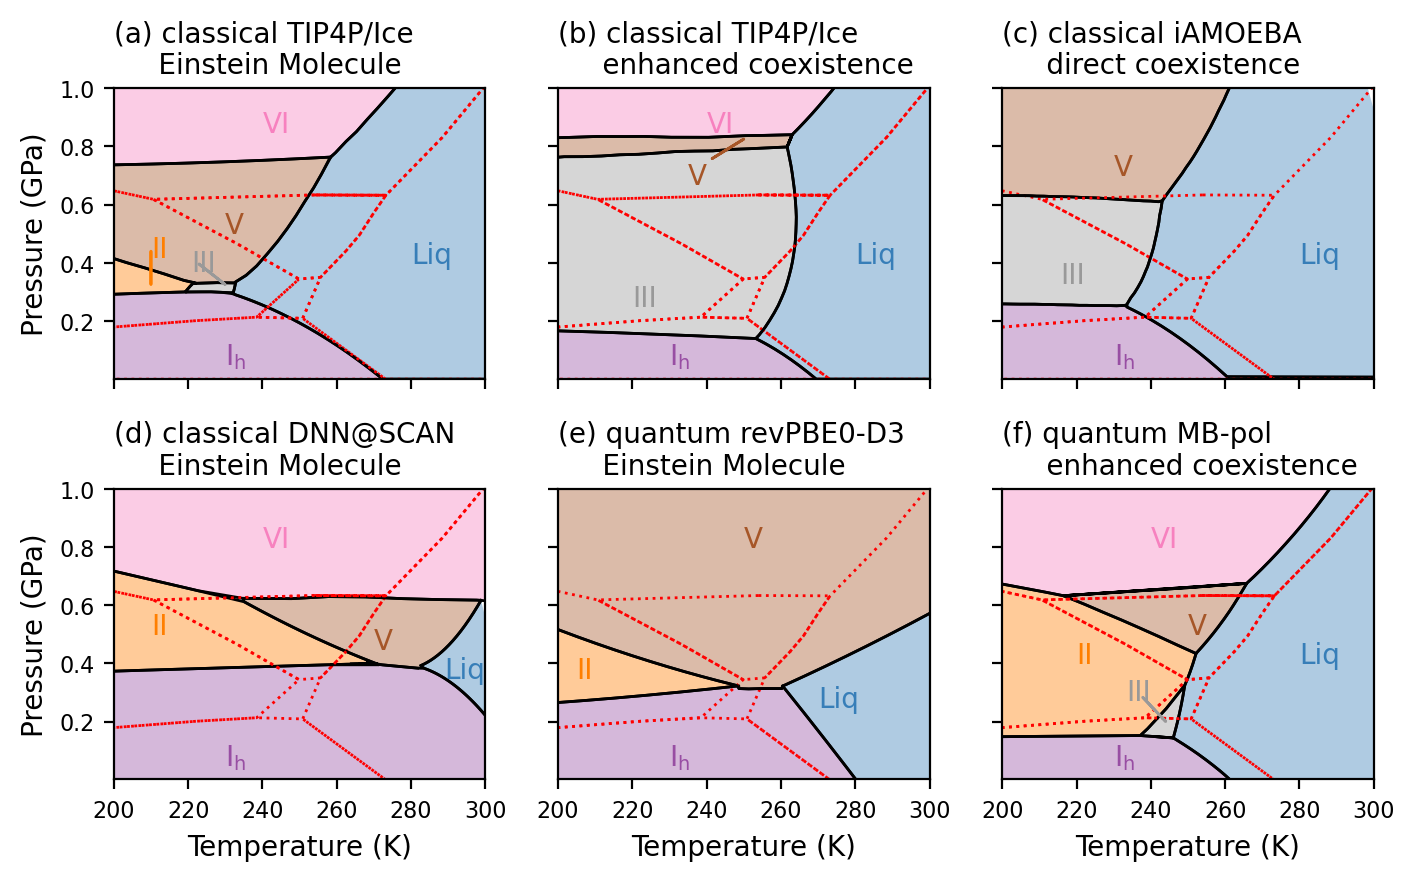

In [185]:
fig,ax=plt.subplots(2,3,figsize=(7.2,4.5),sharey=True,sharex=True)

axs=ax.flatten()
for j, al in enumerate(area_lines_reinhardt.keys()):
    axs[4].fill(area_lines_reinhardt[al][:,0],area_lines_reinhardt[al][:,1]/10000,alpha=0.4,lw=0,color=color_dict[al])
    axs[4].plot(area_lines_reinhardt[al][:,0],area_lines_reinhardt[al][:,1]/10000,lw=1,color='k')
    axs[4].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
for j, al in enumerate(area_lines_zhang.keys()):
    axs[3].fill(area_lines_zhang[al][:,0],area_lines_zhang[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[3].plot(area_lines_zhang[al][:,0],area_lines_zhang[al][:,1],lw=1,color='k')
    axs[3].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_iamoeba.keys()):
    axs[2].fill(area_lines_iamoeba[al][:,0],area_lines_iamoeba[al][:,1]/10000,alpha=0.4,lw=0,color=color_dict[al])
    axs[2].plot(area_lines_iamoeba[al][:,0],area_lines_iamoeba[al][:,1]/10000,lw=1,color='k')
    axs[2].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_tip4p_ice.keys()):
    axs[0].fill(area_lines_tip4p_ice[al][:,0],area_lines_tip4p_ice[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[0].plot(area_lines_tip4p_ice[al][:,0],area_lines_tip4p_ice[al][:,1],lw=1,color='k')
    axs[0].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_tip4p_ice.keys()):
    axs[1].fill(area_lines_tip4p_ice_bore[al][:,0],area_lines_tip4p_ice_bore[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[1].plot(area_lines_tip4p_ice_bore[al][:,0],area_lines_tip4p_ice_bore[al][:,1],lw=1,color='k')
    axs[1].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
    
for j, al in enumerate(area_lines_quantum.keys()):
    axs[5].fill(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,alpha=0.4,lw=0,color=color_dict[al])
    axs[5].plot(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,lw=1,color='k')
    axs[5].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
for axi in axs:
    axi.set_xlim((200,300))
    axi.set_ylim((0.001,1))
axs[0].annotate('(a) classical TIP4P/Ice\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
axs[1].annotate('(b) classical TIP4P/Ice\n     enhanced coexistence',xy=(0,1.05),xycoords='axes fraction')
axs[2].annotate('(c) classical iAMOEBA\n     direct coexistence',xy=(0,1.05),xycoords='axes fraction')
axs[3].annotate('(d) classical DNN@SCAN\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
axs[4].annotate('(e) quantum revPBE0-D3\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
axs[5].annotate('(f) quantum MB-pol\n     enhanced coexistence',xy=(0,1.05),xycoords='axes fraction')


axs[3].set_xlabel('Temperature (K)')
axs[4].set_xlabel('Temperature (K)')
axs[5].set_xlabel('Temperature (K)')

axs[0].set_ylabel('Pressure (GPa)')
axs[3].set_ylabel('Pressure (GPa)')

# Scan
axs[3].annotate('Liq',xy=(289,0.35),color=color_dict['Liq'])
axs[3].annotate('II',xy=(210,0.5),color=color_dict['II'])
axs[3].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[3].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[3].annotate('V',xy=(270, 0.45),color=color_dict['V'])

# revPBE0-D3
axs[4].annotate('Liq',xy=(270,0.25),color=color_dict['Liq'])
axs[4].annotate('II',xy=(205,0.35),color=color_dict['II'])
axs[4].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[4].annotate('V',xy=(250, 0.8),color=color_dict['V'])

# iAmoeba
axs[2].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
#axs[2].annotate('II',xy=(210,0.4),color=color_dict['II'])
#axs[2].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[2].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[2].annotate('V',xy=(230, 0.7),color=color_dict['V'])
axs[2].annotate('III', xy=(215.5, 0.33),color=color_dict['III'])

#TIP4P Einstein Molecule
axs[0].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[0].annotate('VI',xy=(240,0.85),color=color_dict['VI'])
axs[0].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[0].annotate('II',xy=(210,0.325),color=color_dict['II'], xycoords='data',
            xytext=(210,0.4),
            arrowprops=dict(facecolor=color_dict['II'],color=color_dict['II'],headwidth=0.1,width=1),
            horizontalalignment='left', verticalalignment='bottom',
            )
axs[0].annotate('V',xy=(230,0.5),color=color_dict['V'])

axs[0].annotate('III', xy=(230, 0.325),color=color_dict['III'], xycoords='data',
            xytext=(227.5, 0.35),
            arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=0),
            horizontalalignment='right', verticalalignment='bottom',
            )
#TIP4P/Ice Coexistence
axs[1].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[1].annotate('VI',xy=(240,0.85),color=color_dict['VI'])
axs[1].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[1].annotate('V',xy=(250,0.825),color=color_dict['V'],xycoords='data',
            xytext=(240, 0.65),
           arrowprops=dict(facecolor=color_dict['V'],color=color_dict['V'],headwidth=0.1,width=0),
            horizontalalignment='right', verticalalignment='bottom',
            )
axs[1].annotate('III', xy=(220, 0.25),color=color_dict['III'])

# MB-pol
axs[5].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[5].annotate('II',xy=(220,0.4),color=color_dict['II'])

axs[5].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[5].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[5].annotate('V',xy=(250,0.5),color=color_dict['V'])
axs[5].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',
            xytext=(240, 0.35),
            arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),
            horizontalalignment='right', verticalalignment='top',
            )

plt.tight_layout()
plt.savefig('figures/phase_diagram_comp.pdf')
plt.savefig('figures/fig4.pdf')
plt.savefig('figures/phase_diagram_comp.png',dpi=300)

/tmp/ipykernel_7202/1616247524.py:89: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[1].annotate('V',xy=(250,0.825),color=color_dict['V'],xycoords='data',\
/tmp/ipykernel_7202/1616247524.py:102: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[5].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',xytext=(240, 0.35),arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),


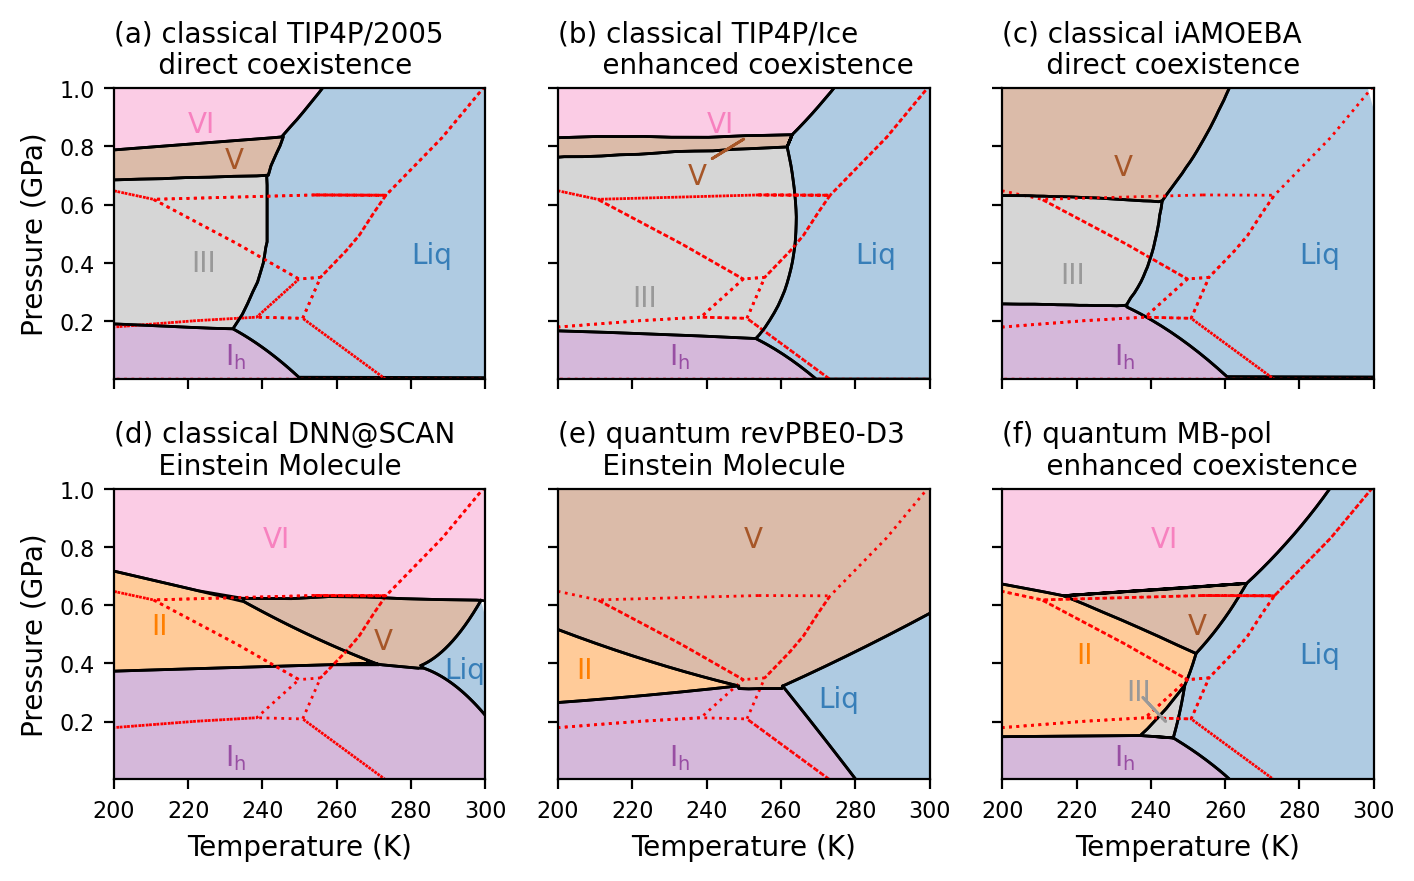

In [186]:
fig,ax=plt.subplots(2,3,figsize=(7.2,4.5),sharey=True,sharex=True)

axs=ax.flatten()
for j, al in enumerate(area_lines_reinhardt.keys()):
    axs[4].fill(area_lines_reinhardt[al][:,0],area_lines_reinhardt[al][:,1]/10000,alpha=0.4,lw=0,color=color_dict[al])
    axs[4].plot(area_lines_reinhardt[al][:,0],area_lines_reinhardt[al][:,1]/10000,lw=1,color='k')
    axs[4].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
for j, al in enumerate(area_lines_zhang.keys()):
    axs[3].fill(area_lines_zhang[al][:,0],area_lines_zhang[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[3].plot(area_lines_zhang[al][:,0],area_lines_zhang[al][:,1],lw=1,color='k')
    axs[3].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_iamoeba.keys()):
    axs[2].fill(area_lines_iamoeba[al][:,0],area_lines_iamoeba[al][:,1]/10000,alpha=0.4,lw=0,color=color_dict[al])
    axs[2].plot(area_lines_iamoeba[al][:,0],area_lines_iamoeba[al][:,1]/10000,lw=1,color='k')
    axs[2].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_tip4p_2005.keys()):
    axs[0].fill(area_lines_tip4p_2005[al][:,0],area_lines_tip4p_2005[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[0].plot(area_lines_tip4p_2005[al][:,0],area_lines_tip4p_2005[al][:,1],lw=1,color='k')
    axs[0].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_tip4p_ice.keys()):
    axs[1].fill(area_lines_tip4p_ice_bore[al][:,0],area_lines_tip4p_ice_bore[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[1].plot(area_lines_tip4p_ice_bore[al][:,0],area_lines_tip4p_ice_bore[al][:,1],lw=1,color='k')
    axs[1].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
    
for j, al in enumerate(area_lines_quantum.keys()):
    axs[5].fill(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,alpha=0.4,lw=0,color=color_dict[al])
    axs[5].plot(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,lw=1,color='k')
    axs[5].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
for axi in axs:
    axi.set_xlim((200,300))
    axi.set_ylim((0.001,1))
axs[0].annotate('(a) classical TIP4P/2005\n     direct coexistence',xy=(0,1.05),xycoords='axes fraction')
axs[1].annotate('(b) classical TIP4P/Ice\n     enhanced coexistence',xy=(0,1.05),xycoords='axes fraction')
axs[2].annotate('(c) classical iAMOEBA\n     direct coexistence',xy=(0,1.05),xycoords='axes fraction')
axs[3].annotate('(d) classical DNN@SCAN\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
axs[4].annotate('(e) quantum revPBE0-D3\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
axs[5].annotate('(f) quantum MB-pol\n     enhanced coexistence',xy=(0,1.05),xycoords='axes fraction')


axs[3].set_xlabel('Temperature (K)')
axs[4].set_xlabel('Temperature (K)')
axs[5].set_xlabel('Temperature (K)')

axs[0].set_ylabel('Pressure (GPa)')
axs[3].set_ylabel('Pressure (GPa)')

# Scan
axs[3].annotate('Liq',xy=(289,0.35),color=color_dict['Liq'])
axs[3].annotate('II',xy=(210,0.5),color=color_dict['II'])
axs[3].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[3].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[3].annotate('V',xy=(270, 0.45),color=color_dict['V'])

# revPBE0-D3
axs[4].annotate('Liq',xy=(270,0.25),color=color_dict['Liq'])
axs[4].annotate('II',xy=(205,0.35),color=color_dict['II'])
axs[4].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[4].annotate('V',xy=(250, 0.8),color=color_dict['V'])

# iAmoeba
axs[2].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[2].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[2].annotate('V',xy=(230, 0.7),color=color_dict['V'])
axs[2].annotate('III', xy=(215.5, 0.33),color=color_dict['III'])

#TIP4P Einstein Molecule
axs[0].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[0].annotate('VI',xy=(220,0.85),color=color_dict['VI'])
axs[0].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[0].annotate('V',xy=(230,0.725),color=color_dict['V'])

axs[0].annotate('III', xy=(230, 0.325),color=color_dict['III'], xycoords='data',
            xytext=(227.5, 0.35),            horizontalalignment='right', verticalalignment='bottom',
            )

#TIP4P/Ice Coexistence
axs[1].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[1].annotate('VI',xy=(240,0.85),color=color_dict['VI'])
axs[1].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[1].annotate('V',xy=(250,0.825),color=color_dict['V'],xycoords='data',\
                xytext=(240, 0.65),arrowprops=dict(facecolor=color_dict['V'],color=color_dict['V'],headwidth=0.1,width=0),
            horizontalalignment='right', verticalalignment='bottom',
            )
axs[1].annotate('III', xy=(220, 0.25),color=color_dict['III'])

# MB-pol
axs[5].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[5].annotate('II',xy=(220,0.4),color=color_dict['II'])

axs[5].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[5].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[5].annotate('V',xy=(250,0.5),color=color_dict['V'])
axs[5].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',xytext=(240, 0.35),arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),
            horizontalalignment='right', verticalalignment='top',
            )

plt.tight_layout()
plt.savefig('figures/phase_diagram_comp_alt.pdf')
plt.savefig('figures/phase_diagram_comp_alt.png',dpi=300)

## Mcbride TIP4PQ/2005

/tmp/ipykernel_7202/2087792466.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axs[1].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',


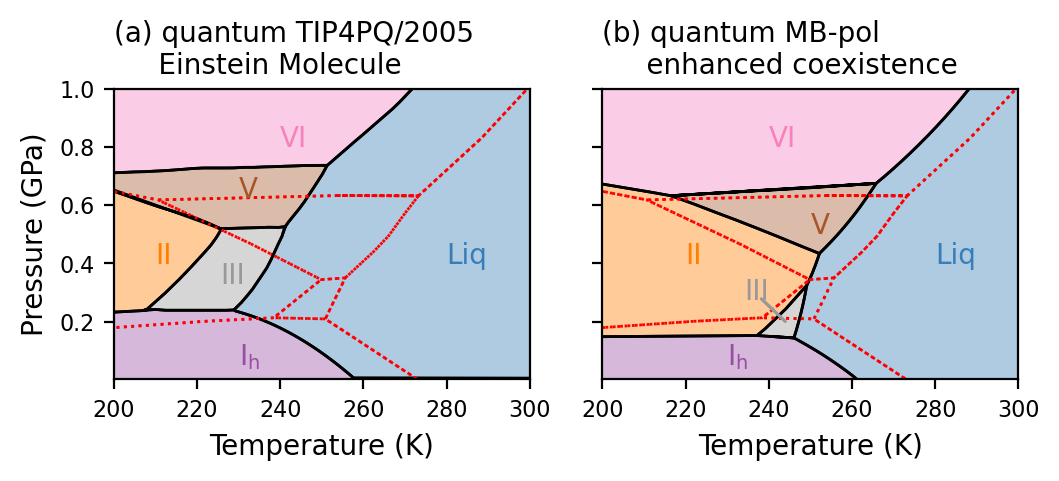

In [187]:
# McBride

fig,ax=plt.subplots(1,2,figsize=(5.4,2.5),sharey=True,sharex=True)
axs=ax.flatten()

for j, al in enumerate(area_lines_quantum.keys()):
    axs[1].fill(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,alpha=0.4,lw=0,color=color_dict[al])
    axs[1].plot(area_lines_quantum[al][:,0],area_lines_quantum[al][:,1]*atm_to_gpa,lw=1,color='k')
    axs[1].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_bride.keys()):
    axs[0].fill(area_lines_bride[al][:,0],area_lines_bride[al][:,1]/10000,alpha=0.4,lw=0,color=color_dict[al])
    axs[0].plot(area_lines_bride[al][:,0],area_lines_bride[al][:,1]/10000,lw=1,color='k')
    axs[0].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

    
for axi in axs:
    axi.set_xlim((200,300))
    axi.set_ylim((0.001,1))
    
axs[0].annotate('(a) quantum TIP4PQ/2005\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
axs[0].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[0].annotate('II',xy=(210,0.4),color=color_dict['II'])
axs[0].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[0].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[0].annotate('V',xy=(230, 0.625),color=color_dict['V'])
axs[0].annotate('III', xy=(225.5, 0.33),color=color_dict['III'])

axs[1].annotate('(b) quantum MB-pol\n     enhanced coexistence',xy=(0,1.05),xycoords='axes fraction')
axs[1].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
axs[1].annotate('II',xy=(220,0.4),color=color_dict['II'])

axs[1].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
axs[1].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
axs[1].annotate('V',xy=(250,0.5),color=color_dict['V'])
axs[1].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',
            xytext=(240, 0.35),
            arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),
            horizontalalignment='right', verticalalignment='top',
            )
plt.tight_layout()
axs[0].set_xlabel('Temperature (K)')
axs[1].set_xlabel('Temperature (K)')
axs[0].set_ylabel('Pressure (GPa)')
plt.tight_layout()

plt.savefig('figures/phase_diagram_tip4pq-2005.png',dpi=300)

plt.savefig('figures/phase_diagram_tip4pq-2005.pdf')

## The TIP4P/Family

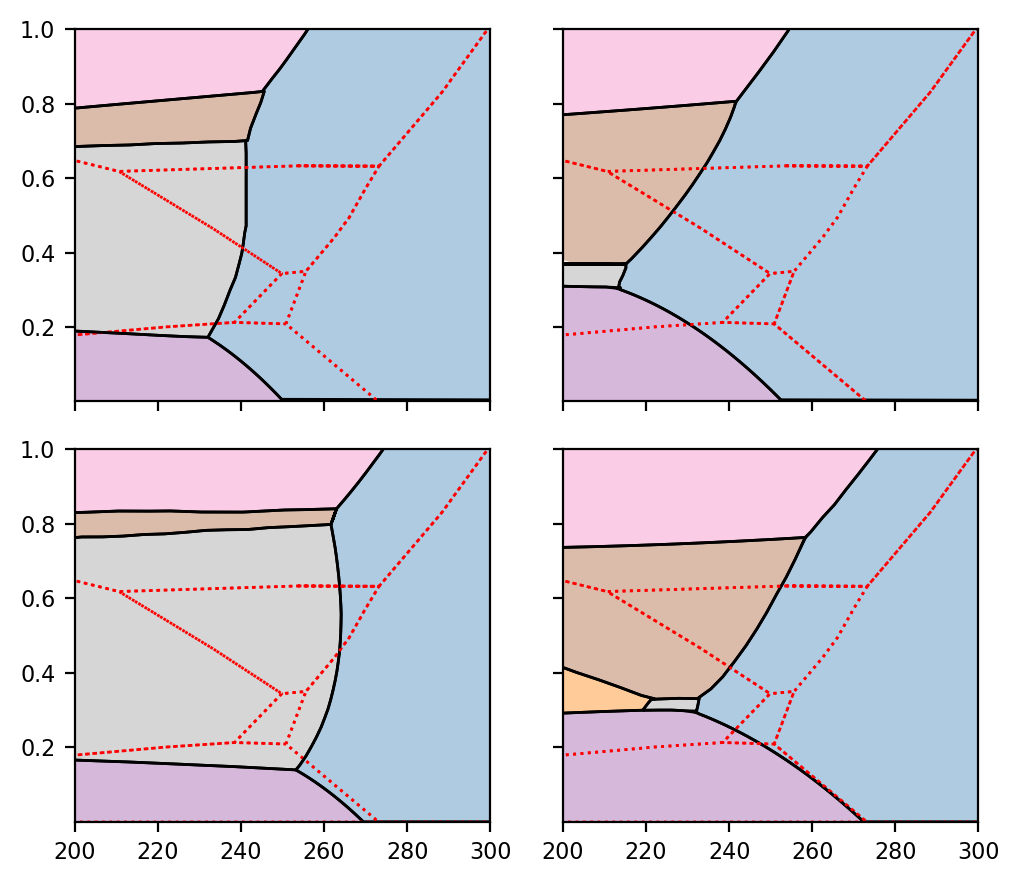

In [188]:
fig,ax=plt.subplots(2,2,figsize=(5.2,4.5),sharey=True,sharex=True)

axs=ax.flatten()

for j, al in enumerate(area_lines_tip4p_2005.keys()):
    axs[0].fill(area_lines_tip4p_2005[al][:,0],area_lines_tip4p_2005[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[0].plot(area_lines_tip4p_2005[al][:,0],area_lines_tip4p_2005[al][:,1],lw=1,color='k')
    axs[0].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_abascal2005general.keys()):
    axs[1].fill(area_lines_abascal2005general[al][:,0],area_lines_abascal2005general[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[1].plot(area_lines_abascal2005general[al][:,0],area_lines_abascal2005general[al][:,1],lw=1,color='k')
    axs[1].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_tip4p_ice_bore.keys()):
    axs[2].fill(area_lines_tip4p_ice_bore[al][:,0],area_lines_tip4p_ice_bore[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[2].plot(area_lines_tip4p_ice_bore[al][:,0],area_lines_tip4p_ice_bore[al][:,1],lw=1,color='k')
    axs[2].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

for j, al in enumerate(area_lines_tip4p_ice.keys()):
    axs[3].fill(area_lines_tip4p_ice[al][:,0],area_lines_tip4p_ice[al][:,1],alpha=0.4,lw=0,color=color_dict[al])
    axs[3].plot(area_lines_tip4p_ice[al][:,0],area_lines_tip4p_ice[al][:,1],lw=1,color='k')
    axs[3].plot(area_lines_experimental[al][:,0],area_lines_experimental[al][:,1],lw=1,color='r',ls='dotted')

        
    

for axi in axs:
    axi.set_xlim((200,300))
    axi.set_ylim((0.001,1))
# axs[0].annotate('(a) classical TIP4P/2005\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
# axs[1].annotate('(b) classical TIP4P/2005\n     direct coexistence',xy=(0,1.05),xycoords='axes fraction')
# axs[2].annotate('(c) classical TIP4P/Ice\n     Einstein Molecule',xy=(0,1.05),xycoords='axes fraction')
# axs[3].annotate('(d) classical TIP4P/Ice\n     direct coexistence',xy=(0,1.05),xycoords='axes fraction')



# axs[2].set_xlabel('Temperature (K)')
# axs[3].set_xlabel('Temperature (K)')

# axs[0].set_ylabel('Pressure (GPa)')
# axs[2].set_ylabel('Pressure (GPa)')

# # Scan
# axs[3].annotate('Liq',xy=(289,0.35),color=color_dict['Liq'])
# axs[3].annotate('II',xy=(210,0.5),color=color_dict['II'])
# axs[3].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
# axs[3].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
# axs[3].annotate('V',xy=(270, 0.45),color=color_dict['V'])

# # revPBE0-D3
# axs[4].annotate('Liq',xy=(270,0.25),color=color_dict['Liq'])
# axs[4].annotate('II',xy=(205,0.35),color=color_dict['II'])
# axs[4].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
# axs[4].annotate('V',xy=(250, 0.8),color=color_dict['V'])

# # iAmoeba
# axs[2].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
# axs[2].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
# axs[2].annotate('V',xy=(230, 0.7),color=color_dict['V'])
# axs[2].annotate('III', xy=(215.5, 0.33),color=color_dict['III'])

# #TIP4P Einstein Molecule
# axs[0].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
# axs[0].annotate('VI',xy=(220,0.85),color=color_dict['VI'])
# axs[0].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
# axs[0].annotate('V',xy=(230,0.725),color=color_dict['V'])

# axs[0].annotate('III', xy=(230, 0.325),color=color_dict['III'], xycoords='data',
#             xytext=(227.5, 0.35),            horizontalalignment='right', verticalalignment='bottom',
#             )

# #TIP4P/Ice Coexistence
# axs[1].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
# axs[1].annotate('VI',xy=(240,0.85),color=color_dict['VI'])
# axs[1].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
# axs[1].annotate('V',xy=(250,0.825),color=color_dict['V'],xycoords='data',\
#                 xytext=(240, 0.65),arrowprops=dict(facecolor=color_dict['V'],color=color_dict['V'],headwidth=0.1,width=0),
#             horizontalalignment='right', verticalalignment='bottom',
#             )
# axs[1].annotate('III', xy=(220, 0.25),color=color_dict['III'])

# # MB-pol
# axs[5].annotate('Liq',xy=(280,0.4),color=color_dict['Liq'])
# axs[5].annotate('II',xy=(220,0.4),color=color_dict['II'])

# axs[5].annotate('VI',xy=(240,0.8),color=color_dict['VI'])
# axs[5].annotate('I$_\mathrm{h}$',xy=(230,0.05),color=color_dict['Ih'])
# axs[5].annotate('V',xy=(250,0.5),color=color_dict['V'])
# axs[5].annotate('III', xy=(244, 0.20),color=color_dict['III'], xycoords='data',xytext=(240, 0.35),arrowprops=dict(facecolor=color_dict['III'],color=color_dict['III'],headwidth=0.1,width=1),
#             horizontalalignment='right', verticalalignment='top',
#             )

plt.tight_layout()
plt.savefig('figures/phase_diagram_tip4p.pdf')
plt.savefig('figures/phase_diagram_tip4p.png',dpi=300)

## Store latex tables

### Triple points

In [189]:

names=['triple_points_classical.tex','triple_points_classical.tex','triple_points_quantum.tex']
dicts=[trip_pts_classical,trip_pts_classical,trip_pts_quantum]
for name,trip_pts in zip(names,dicts):
    with open('tables/{}'.format(name),'w') as fp:
        fp.write('\\begin{tabular}{lrr}\n\\hline\\hline\n')
        fp.write('&P/GPa&T/K\\\\\n\\hline\n')
        for key in trip_pts:
            line='{}&{:.4f}&{:.1f}\\\\\n'.format('-'.join(key.split()).replace('Liquid','Liq').replace('Ice', '').replace('Ih','I$_{\mathrm h}$'),trip_pts[key][1]*atm_to_gpa,trip_pts[key][0])
            fp.write(line)
        fp.write('\\hline\\hline\n\end{tabular}')
!cat tables/*.tex

\begin{tabular}{lrr}
\hline\hline
&P/GPa&T/K\\
\hline
I$_{\mathrm h}$-Liq&0.0001&266.2\\
I$_{\mathrm h}$-Liq&0.1013&255.0\\
\hline
II-Liq&0.2026&244.6\\
II-Liq&0.3040&251.0\\
II-Liq&0.4053&254.4\\
II-Liq&0.5066&255.5\\
II-Liq&0.6079&256.6\\
\hline
III-Liq&0.2026&247.4\\
III-Liq&0.3040&249.0\\
III-Liq&0.5066&250.5\\
III-Liq&0.6079&250.2\\
\hline
V-Liq&0.5066&255.8\\
V-Liq&0.6079&260.3\\
\hline
VI-Liq&0.7093&266.1\\
VI-Liq&0.9119&279.9\\
\hline
\hline
\end{tabular}\begin{tabular}{lrr}
\hline\hline
&P/GPa&T/K\\
\hline
I$_{\mathrm h}$-Liq&0.0001&262.5\\
I$_{\mathrm h}$-Liq&0.1013&250.3\\
\hline
II-Liq&0.2026&244.6\\
II-Liq&0.3040&250.9\\
II-Liq&0.4053&254.3\\
II-Liq&0.5066&255.2\\
II-Liq&0.6079&256.1\\
\hline
III-Liq&0.2026&243.2\\
III-Liq&0.3040&245.2\\
III-Liq&0.5066&247.7\\
III-Liq&0.6079&247.4\\
\hline
V-Liq&0.5066&250.0\\
V-Liq&0.6079&255.2\\
\hline
VI-Liq&0.7093&263.1\\
VI-Liq&0.9119&277.0\\
\hline
\hline
\end{tabular}\begin{tabular}{lrr}
\hline\hline
&P/GPa&T/K\\
\hline
I$_{\mathrm 

### Melting points

In [ ]:
names=['melting_points_nn.tex','melting_points_classical.tex','melting_points_quantum.tex']
dicts=[MeltingPointsDNN,MeltingPointsClassical,MeltingPointsQuantum]
for name,MeltingPoints in zip(names,dicts):
    with open('tables/{}'.format(name),'w') as fp:
        fp.write('\\begin{tabular}{lrr}\n\\hline\\hline\n')
        fp.write('&P/GPa&T/K\\\\\n\\hline\n')
        for key in MeltingPoints.keys():
            line=''
            for i in range(len(MeltingPoints[key])):
                line+='{}&{:.4f}&{:.1f}\\\\\n'.format('-'.join(key.split('_')).replace('Liquid','Liq').replace('Ice', '').replace('Ih','I$_{\mathrm h}$'),MeltingPoints[key][i][0]*atm_to_gpa,MeltingPoints[key][i][1])
            fp.write(line+'\\hline\n')
        fp.write('\\hline\n\end{tabular}')
!cat tables/melting_points*.tex